In [1]:
# conda install holidays=0.24 prophet=1.1.2 matplotlib pandas seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", category=NameError)
# warnings.simplefilter("ignore", category=SettingWithCopyWarning)

# The bigger picture
The business objective is to create a forecasting model to predict New york City's Electricity consumption.
To achieve this objective we are using Facebook's Prophet model. That means we will need a timestamp and electricity consumed at that specific timestamp.

### Overview of facebook prophet
Prophet is designed to handle forecasting tasks that feature the following attibutes;
1. Time series data captured at the hourly, daily or weekly level with atleast a full year of historical data
2. Strong seasonality effects e.g., daily, weekly or yearly
3. Holidays and other special one time events that dont follow the seasonality patters but occur irregulary
4. Missing data and outliers
5. Significant trend changes due to new features

Prophet always requires a pandas DF with two columns
1. ds for datestamp is of type either datestamp or timestamp
2. a numeric column containing the measurement to focecast for our case electricity consumption

## Load data

In [4]:
df_raw = pd.read_csv("../data/electric-consumption.csv")

In [5]:
# Size of the dataframe
df_raw.shape

(447849, 27)

we have 447849 rows and 27 columns

In [6]:
# Look at the types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447849 entries, 0 to 447848
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    446368 non-null  object 
 1   Borough             447849 non-null  object 
 2   Account Name        447849 non-null  object 
 3   Location            436128 non-null  object 
 4   Meter AMR           447622 non-null  object 
 5   Meter Scope         23867 non-null   object 
 6   TDS #               445111 non-null  float64
 7   EDP                 447849 non-null  int64  
 8   RC Code             447849 non-null  object 
 9   Funding Source      447849 non-null  object 
 10  AMP #               445962 non-null  object 
 11  Vendor Name         447849 non-null  object 
 12  UMIS BILL ID        447849 non-null  int64  
 13  Revenue Month       447849 non-null  object 
 14  Service Start Date  447841 non-null  object 
 15  Service End Date    447841 non-nul

No need for imputing since prophet can handle missing data

In [7]:
# Overview of numerical columns
df_raw.describe()

,TDS #,EDP,UMIS BILL ID,# days,Current Charges,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
count,445111.000000,447849.000000,4.478490e+05,447841.000000,4.478490e+05,4.478490e+05,4.478490e+05,447849.000000,447849.000000,4.478490e+05
mean,117.512099,425.015438,6.355232e+06,30.447960,4.277735e+03,3.115645e+04,1.431691e+03,63.944056,903.329622,1.942714e+03
std,128.881800,186.965308,3.209486e+06,1.898483,8.071365e+03,4.896050e+04,3.468343e+03,627.156668,1567.021090,4.679456e+03
min,1.000000,63.000000,1.726303e+06,1.000000,-1.068744e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,-5.939643e+04
25%,33.000000,225.000000,3.543961e+06,29.000000,6.275200e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,64.000000,426.000000,5.658874e+06,30.000000,2.313950e+03,1.340000e+04,5.664600e+02,23.940000,288.050000,9.768900e+02
75%,150.000000,555.000000,9.282883e+06,32.000000,5.606110e+03,4.608000e+04,2.034260e+03,90.340000,1323.160000,2.822310e+03
max,582.000000,999.000000,1.224390e+07,396.000000,3.551569e+06,1.779600e+06,1.652807e+06,329074.000000,137814.280000,1.898762e+06


### Feature selection
Guided by business objective to predict Electricity consumption of the whole of New York

In [8]:
df_raw.columns

Index(['Development Name', 'Borough', 'Account Name', 'Location', 'Meter AMR',
       'Meter Scope', 'TDS #', 'EDP', 'RC Code', 'Funding Source', 'AMP #',
       'Vendor Name', 'UMIS BILL ID', 'Revenue Month', 'Service Start Date',
       'Service End Date', '# days', 'Meter Number', 'Estimated',
       'Current Charges', 'Rate Class', 'Bill Analyzed', 'Consumption (KWH)',
       'KWH Charges', 'Consumption (KW)', 'KW Charges', 'Other charges'],
      dtype='object')

In [9]:
#Drop some columns that have no useful data to achieve the business objective(forecast electricity consumption of New York)
dropped_features = ['Development Name', 'Account Name', 'Location', 'UMIS BILL ID', 
                    "Borough", 'Meter AMR', 'Vendor Name','Meter Scope', 'TDS #', 
                    'EDP', 'RC Code', 'Funding Source', 'Meter Number', 
                    'Bill Analyzed', 'AMP #', 'Rate Class', 'Estimated']
df_dropped = df_raw.drop(columns=dropped_features, axis=1)
df_dropped.head(2)

,Revenue Month,Service Start Date,Service End Date,# days,Current Charges,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,2023-01,12/23/2022,01/25/2023,33.0,10805.65,98400.0,5142.39,0.0,0.0,5663.26
1,2023-01,12/23/2022,01/25/2023,33.0,9927.14,90400.0,4724.31,0.0,0.0,5202.83


In [10]:
# Columns which can be used for timestamps and amount of electricity consumed
df_dropped[["Service Start Date", "Service End Date", "Revenue Month", "# days", "Consumption (KWH)", "KWH Charges", 'Consumption (KW)', 'KW Charges']].sample(frac=1).head()

,Service Start Date,Service End Date,Revenue Month,# days,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges
267667,11/23/2015,12/24/2015,2015-12,31.0,0.0,0.00,267.84,5334.08
420238,12/24/2009,01/26/2010,2010-01,33.0,39280.0,4400.82,0.00,0.00
426694,04/26/2010,05/24/2010,2010-05,28.0,24720.0,1417.94,0.00,0.00
264167,04/24/2015,05/26/2015,2015-05,32.0,32880.0,1351.27,0.00,0.00
323625,02/25/2014,03/26/2014,2014-03,29.0,846.0,59.49,1.62,0.00


##### Findings
The dataset contains Monthly consumption and cost data.

Notice that if KWH is entered KW is not entered and if KW is entered KWH is not entered.
So this KWH and KW is electricity consumed in a specific time frame i.e., Service End Date - Service Start Date = # days 

In [11]:
# Compare which column to drop between KWH and KW
(df_dropped["Consumption (KWH)"] == 0).sum(), (df_dropped["Consumption (KW)"] == 0).sum()

(149866, 186148)

In [12]:
# drop "Consumption (KW)" and "KW Charges"  has most zeros
df_dropped = df_dropped.drop(columns=["Consumption (KW)", "KW Charges" ], axis=1)

In [13]:
# filter out outliers
def filter_outliers(df, column):
    # Check and filter outliers in terms of days
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [14]:
df_filtered = filter_outliers(df_dropped, "# days")

In [15]:
df_filtered.shape, df_dropped.shape

((447119, 8), (447849, 8))

In [16]:
((df_raw.shape[0] - df_filtered.shape[0])/df_dropped.shape[0])*100

0.16300136876491853

Only lost 0.163% of data after removing outliers

In [17]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447119 entries, 0 to 447848
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Revenue Month       447119 non-null  object 
 1   Service Start Date  447119 non-null  object 
 2   Service End Date    447119 non-null  object 
 3   # days              447119 non-null  float64
 4   Current Charges     447119 non-null  float64
 5   Consumption (KWH)   447119 non-null  float64
 6   KWH Charges         447119 non-null  float64
 7   Other charges       447119 non-null  float64
dtypes: float64(5), object(3)
memory usage: 30.7+ MB


No NaN after feature selection

In [18]:
# save the df after dropping the columns and removing outliers and casting types
df_filtered.to_csv("../data/feature-selected-E-consumption.csv")

### Feature engineering

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv("../data/feature-selected-E-consumption.csv")

In [21]:
df.head()

,Unnamed: 0,Revenue Month,Service Start Date,Service End Date,# days,Current Charges,Consumption (KWH),KWH Charges,Other charges
0,0,2023-01,12/23/2022,01/25/2023,33.0,10805.65,98400.0,5142.39,5663.26
1,1,2023-01,12/23/2022,01/25/2023,33.0,9927.14,90400.0,4724.31,5202.83
2,2,2023-01,12/23/2022,01/25/2023,33.0,9092.54,82800.0,4327.13,4765.41
3,3,2023-01,12/23/2022,01/25/2023,33.0,3755.58,0.0,0.00,1968.30
4,4,2023-01,12/23/2022,01/25/2023,33.0,3342.30,0.0,0.00,1751.70


In [22]:
df.describe()

,Unnamed: 0,# days,Current Charges,Consumption (KWH),KWH Charges,Other charges
count,447119.000000,447119.000000,4.471190e+05,4.471190e+05,4.471190e+05,4.471190e+05
mean,223963.488194,30.467442,4.272508e+03,3.113518e+04,1.429728e+03,1.939665e+03
std,129274.757424,1.433577,8.048631e+03,4.890025e+04,3.452080e+03,4.671987e+03
min,0.000000,25.000000,-1.068744e+04,0.000000e+00,0.000000e+00,-5.939643e+04
25%,112011.500000,29.000000,6.276800e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,223975.000000,30.000000,2.313340e+03,1.338000e+04,5.659600e+02,9.763500e+02
75%,335906.500000,32.000000,5.602845e+03,4.608000e+04,2.033840e+03,2.820310e+03
max,447848.000000,36.000000,3.551569e+06,1.779600e+06,1.652807e+06,1.898762e+06


The number of days lies betwee 25 and 36

In [23]:
# 
df["# days"].max(), df["# days"].min(), df["# days"].mode()

(36.0,
 25.0,
 0    29.0
 Name: # days, dtype: float64)

#### Relationship between variables

In [24]:
# filter out outliers
def filter_outliers(df, column):
    # Check and filter outliers in terms of days
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [25]:
# filter out outliers
df_filtered = filter_outliers(df, "Consumption (KWH)")
df_filtered = filter_outliers(df, "KWH Charges")

Text(37.597222222222214, 0.5, 'KWH Charges')

<Figure size 1200x600 with 0 Axes>

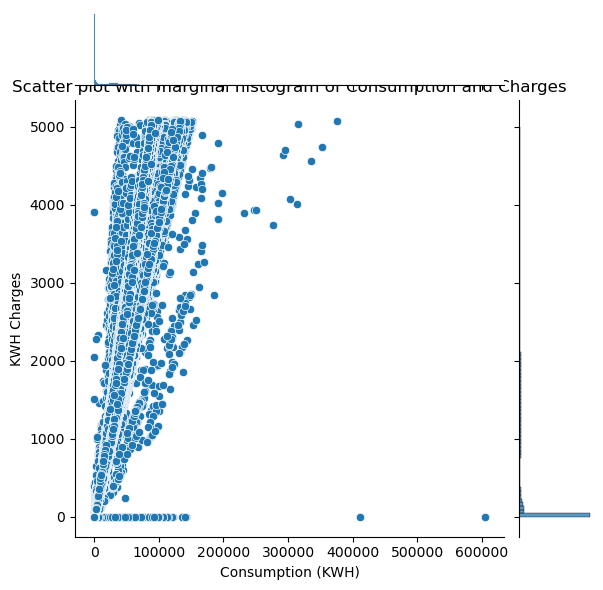

In [26]:
# confirm collinearity between Consumption and Charges should have an upward trend
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.jointplot(
    x="Consumption (KWH)", y="KWH Charges",
    edgecolor="white",
    data=df_filtered
)
plt.title("Scatter plot with marginal histogram of Consumption and Charges")
plt.xlabel("Consumption (KWH)")
plt.ylabel("KWH Charges")

Correlation strong between charges and electricity consumed therefore can use charges for

### Identify trend and seasonality

In [27]:
import pandas as pd
import prophet as Prophet
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv("../data/feature-selected-E-consumption.csv")

In [29]:
# To forecast Electricity consumption we only need the features
df_KWH = df[['Service End Date', 'Consumption (KWH)']]

In [ ]:
df_KWH['Service End Date'] = pd.to_datetime(df_KWH['Service End Date'])

In [31]:
df_KWH.columns = ["ds", "y"]

In [32]:
df_KWH.head(2)

,ds,y
0,2023-01-25,98400.0
1,2023-01-25,90400.0


Facebooks Prophet model decomponses using fourier coefficient for the seasonal components

In [33]:
from prophet import Prophet

In [34]:
df_KWH["ds"].min(), df_KWH["ds"].max()

(Timestamp('2010-01-20 00:00:00'), Timestamp('2023-01-30 00:00:00'))

Data points from jan 25 2017 to jan 30 2023

06:19:54 - cmdstanpy - INFO - Chain [1] start processing
06:20:45 - cmdstanpy - INFO - Chain [1] done processing


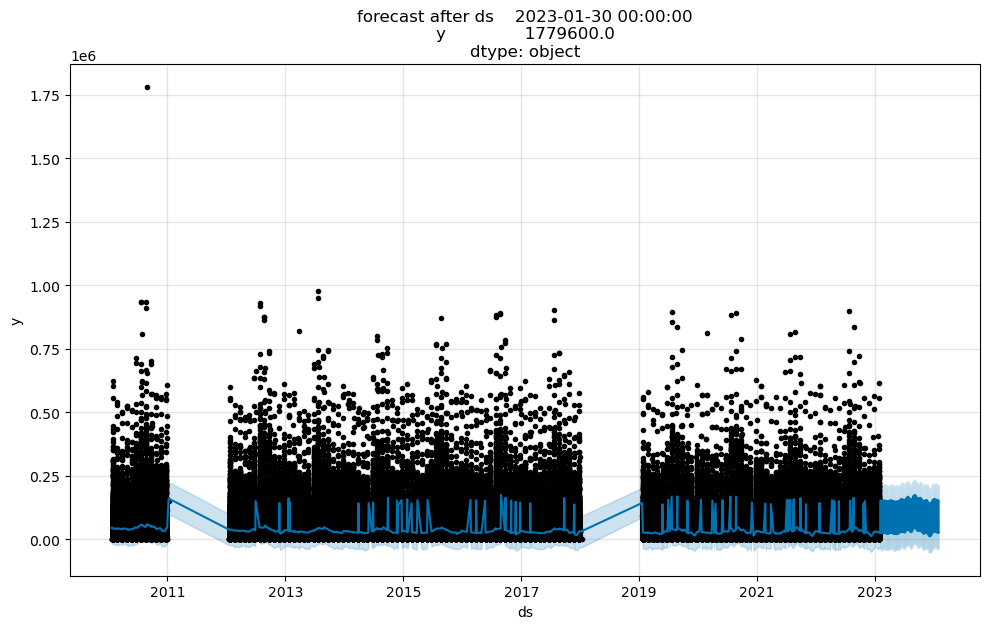

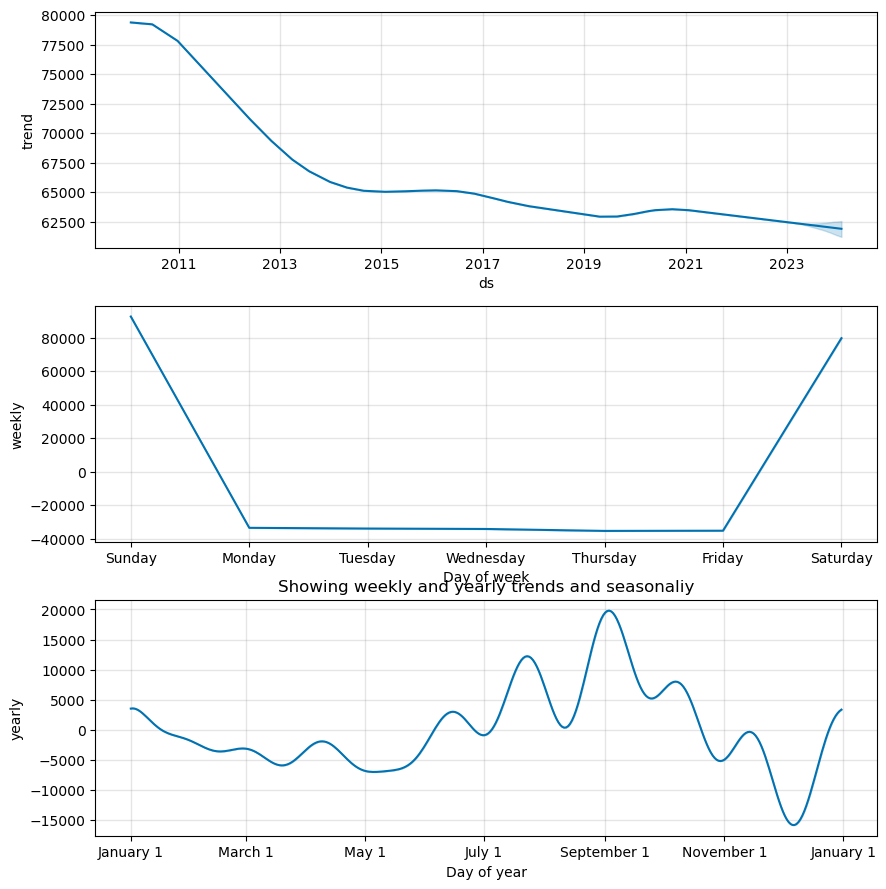

In [35]:

# Looing at seasonality and trend
df_temp = df_KWH.copy()

# Fit the prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)  # Enable yearly and weekly seasonality
model.fit(df_temp)

# a DF for futer predictions
future = model.make_future_dataframe(periods=365, freq='D')  # Forecast for the next 1 year
forecast = model.predict(future)

# Plot the forecast to visualize the overall trend
fig = model.plot(forecast)
plt.title(f"forecast after {df_temp.max()}")
plt.show()

# Plot the seasonal and trend components
# Show the trend and seasonal components
fig2 = model.plot_components(forecast) 
plt.title(f"Showing weekly and yearly trends and seasonaliy")
plt.show()


### Feature Engineering

In [36]:
import pandas as pd

In [37]:
df = pd.read_csv("../data/feature-selected-E-consumption.csv",)

#### Create a daily electricity consumption dataframe

In [38]:
df_daily = df[['Service End Date', 'KWH Charges']].copy()
df_daily.columns = ["ds", "y"]

In [39]:
df_daily["ds"] = pd.to_datetime(df_daily["ds"])

In [40]:
df_daily.sort_values(by='ds').head(5)

,ds,y
412918,2010-01-20,0.00
412930,2010-01-20,0.00
412942,2010-01-20,0.00
412954,2010-01-20,0.00
412966,2010-01-20,3.34


In [41]:
# save daily dataset
df_daily.to_csv("../data/Daily-EC.csv")

#### Create a monthly electricity consumption dataframe

In [42]:
import pandas as pd

In [43]:
df_daily=pd.read_csv("../data/Daily-EC.csv")

In [44]:
df_monthly = df_daily.groupby(pd.PeriodIndex(df_daily['ds'], freq='M'))['y'].mean().to_timestamp().reset_index()

In [45]:
df_monthly.head()

,ds,y
0,2010-01-01,2634.187555
1,2010-02-01,2240.286194
2,2010-03-01,2113.626353
3,2010-04-01,2136.692792
4,2010-05-01,2127.280637


In [46]:
# save the monthly consumption dataset
df_monthly.to_csv("../data/Monthly-EC.csv")

#### Create a yealy electricity consumption dataframe

In [47]:
df_monthly = pd.read_csv("../data/Monthly-EC.csv")

In [48]:
df_yearly = df_monthly.groupby(pd.PeriodIndex(df_monthly['ds'], freq='Y'))['y'].mean().to_timestamp().reset_index()

In [49]:
df_yearly.head()

,ds,y
0,2010-01-01,2572.455456
1,2011-01-01,5148.290000
2,2012-01-01,2088.920572
3,2013-01-01,1793.071227
4,2014-01-01,1637.173312


In [50]:
df_yearly.to_csv("../data/Yearly-EC.csv")

#### Visualize the output of feature engineering

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
df_daily = pd.read_csv("../data/Daily-EC.csv")
df_monthly = pd.read_csv("../data/Monthly-EC.csv")
df_yearly = pd.read_csv("../data/Yearly-EC.csv")

In [53]:
# a plot for daily consumption
def visualize(df, type):
    plt.figure(figsize=(20, 13))
    df.plot(x="ds", y="y")
    plt.title(f"Line Plot of {type} consumption of electricity")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.rc('xtick', labelsize=10)
    plt.ylabel("Consumption (KWH)")
    plt.show()

<Figure size 2000x1300 with 0 Axes>

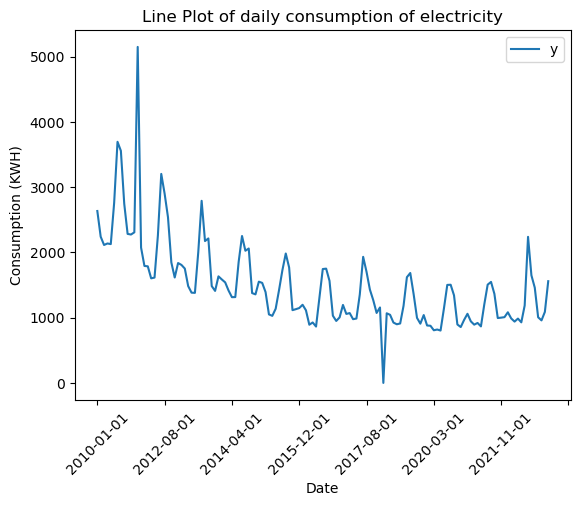

In [54]:
visualize(df_monthly, "daily")

<Figure size 2000x1300 with 0 Axes>

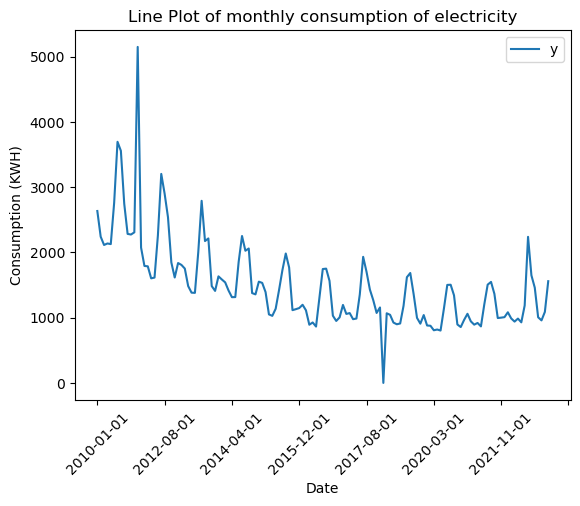

In [55]:
# a plot for monthly consumption
visualize(df_monthly, "monthly")

<Figure size 2000x1300 with 0 Axes>

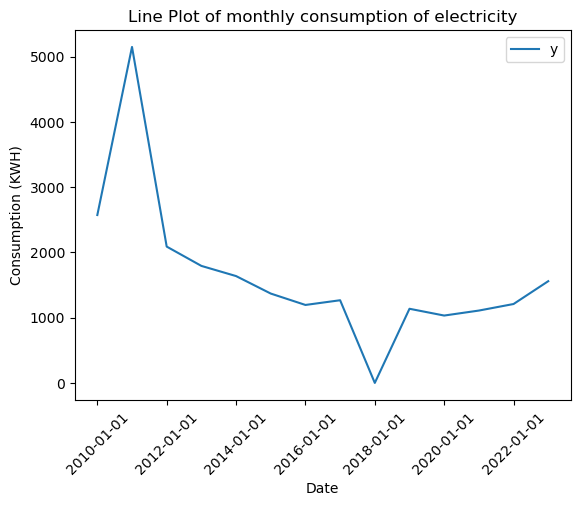

In [56]:
# a plot for yealy consumption
visualize(df_yearly, "monthly")

### Training without tuning

In [4]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn import metrics
from prophet.plot import add_changepoints_to_plot
# Build and training the model without tuning script
class TrainModel():
    def __init__(self, data, time_unit, model):
        self.data = data
        self.time_unit = time_unit
        self.model = model
        self.forecast = None
        self.future = None
        
        
    # Train model
    def fit_model(self):
        model = self.model
        model.fit(self.data)
        self.model = model
    
    # Make forecast for a given frequency of time
    def get_forecast(self, time_period, freq, growth=None, cap=1000, floor=None):
        future = self.model.make_future_dataframe(periods=time_period, freq=freq)
        
        if growth == "logistic":
            future["cap"] = cap
            
        if floor is not None:
            future["floor"] = floor
            
        forecast = self.model.predict(future)
        
        self.future = future
        self.forecast = forecast
    
    # plot the forecast together with history
    def plot_forecast(self):
        if self.forecast is not None:
            self.model.plot(self.forecast)
        else:
            print("Get forecast first before plotting forecast.")
            
    def plot_forecast_components(self):
        if self.forecast is not None:
            self.model.plot_components(self.forecast)
        else:
            print("Get forecast first before plotting forecast components")
    
    def add_changepoints_to_plot(self, m):
        if self.forecast is not None:
            fig = self.model.plot(self.forecast)
            a = add_changepoints_to_plot(fig.gca(), m, self.forecast)
        else:
            print("Get forecast first before plotting forecast.")
            
    def evaluate_daily(self):
        forecast = self.forecast["yhat"]
        y_true = self.data["y"].values[-len(forecast):]
        forecast = forecast.values
        
        y_pred = forecast[:(len(forecast))]

        mean_abs_error = metrics.mean_absolute_error(y_true, y_pred)
        mean_abs_percentage = metrics.mean_absolute_percentage_error(y_true, y_pred)
        r2 = metrics.r2_score(y_true, y_pred)
        
        print("Mean Absolute Error :", mean_abs_error)
        print("Mean Absolute Percentage Error :", mean_abs_percentage)
        print("R^2 Score :", r2)
        
        plt.plot(forecast, c='orange', label='Predicted')
        plt.plot(y_true, c='blue', label='Actual')
        plt.legend(loc='lower right')
        plt.show()
        
    def evaluate_forecast(self, time_period):
        forecast = self.forecast["yhat"]
        y_true = self.data["y"].values[-len(forecast):]
        y_pred = forecast[:(len(forecast)-time_period)]

        mean_abs_error = metrics.mean_absolute_error(y_true, y_pred)
        mean_abs_percentage = metrics.mean_absolute_percentage_error(y_true, y_pred)
        r2 = metrics.r2_score(y_true, y_pred)
        
        print("Mean Absolute Error :", mean_abs_error)
        print("Mean Absolute Percentage Error :", mean_abs_percentage)
        print("R^2 Score :", r2)
        
        plt.plot(forecast, c='orange', label='Predicted')
        plt.plot(y_true, c='blue', label='Actual')
        plt.legend(loc='lower right')
        plt.show()

#### Forecast daily electricity consumption

In [58]:
daily_df = pd.read_csv("../data/Daily-EC.csv", usecols=["ds","y"])

In [59]:
daily_df.head()

,ds,y
0,2023-01-25,5142.39
1,2023-01-25,4724.31
2,2023-01-25,4327.13
3,2023-01-25,0.00
4,2023-01-25,0.00


In [60]:
daily_prophet = Prophet(daily_seasonality=True)
daily_modelV1 = TrainModel(daily_df, "daily", daily_prophet)
daily_modelV1.fit_model()
daily_modelV1.get_forecast(time_period=365, freq='D')

18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing


##### future dataframe

In [61]:
daily_modelV1.future.tail()

,ds
1025,2024-01-26
1026,2024-01-27
1027,2024-01-28
1028,2024-01-29
1029,2024-01-30


In [62]:
daily_modelV1.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1025,2024-01-26,1350.641770,-2851.779972,5889.776366
1026,2024-01-27,8438.157671,4158.999394,12570.012529
1027,2024-01-28,8954.207490,4446.258898,13237.550624
1028,2024-01-29,1564.859618,-2760.251387,5900.356036
1029,2024-01-30,1544.608093,-2950.174527,5678.312690


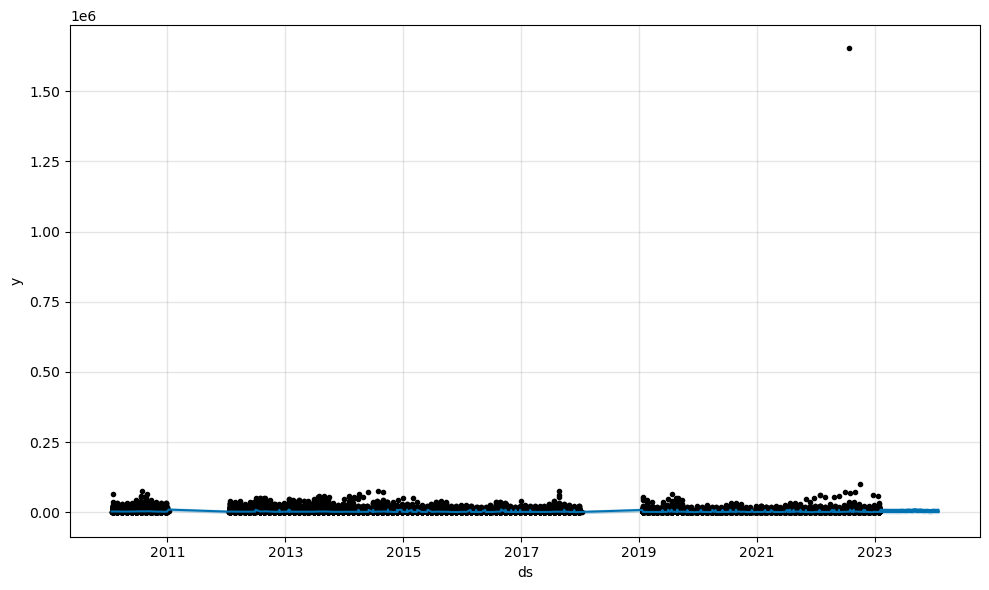

In [63]:
daily_modelV1.plot_forecast()

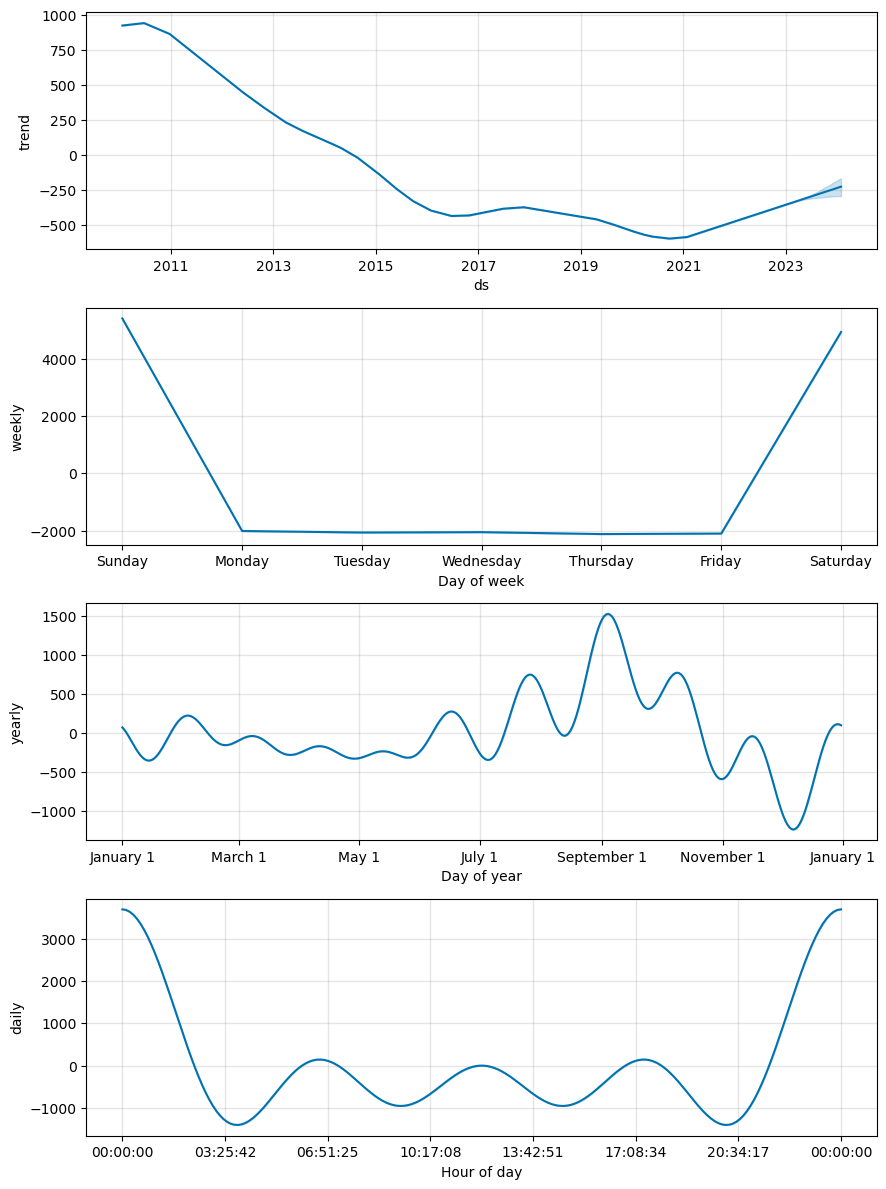

In [64]:
daily_modelV1.plot_forecast_components()

Mean Absolute Error : 2232.3735887943685
Mean Absolute Percentage Error : 4.129352978913392e+18
R^2 Score : -2.647313291124505


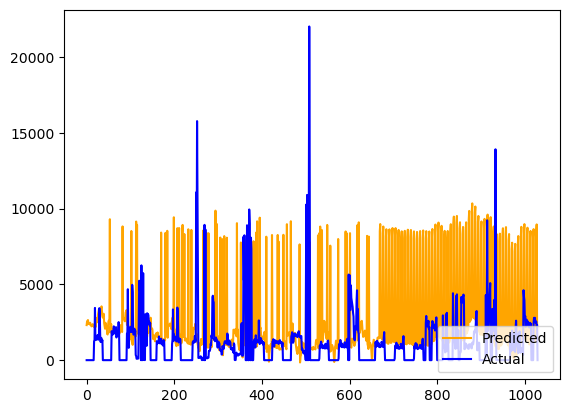

In [66]:
# Evaluate model
daily_modelV1.evaluate_daily()

#### Forecast Monthly electricity consumption

In [4]:
import pandas as pd
from prophet import Prophet

In [5]:
monthly_df = pd.read_csv("../data/Monthly-EC.csv", usecols=["ds", "y"])

In [32]:
monthly_prophet = Prophet()

In [33]:
monthly_modelV1 = TrainModel(monthly_df, "monthly", monthly_prophet)
monthly_modelV1.fit_model()
monthly_modelV1.get_forecast(time_period=24, freq='M')

18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing


##### Future monthly df

In [35]:
monthly_modelV1.future.tail()

,ds
154,2024-08-31
155,2024-09-30
156,2024-10-31
157,2024-11-30
158,2024-12-31


##### Forecast

In [36]:
monthly_modelV1.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
154,2024-08-31,1394.719728,1032.447110,1729.357888
155,2024-09-30,898.472182,546.526158,1245.514479
156,2024-10-31,878.812228,536.052247,1262.866539
157,2024-11-30,970.644486,616.957301,1366.993851
158,2024-12-31,1301.273661,916.493555,1662.740011


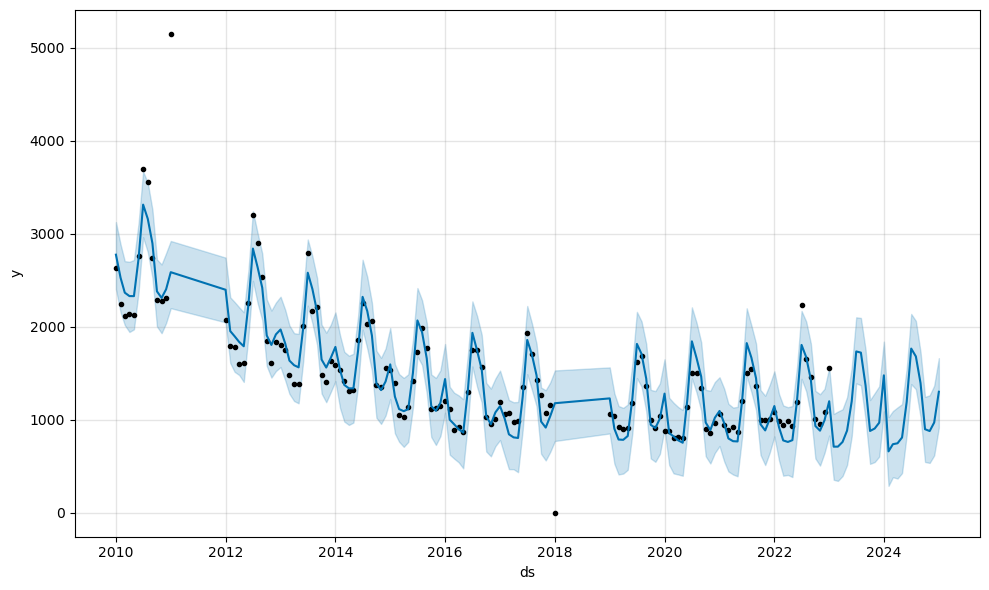

In [37]:
monthly_modelV1.plot_forecast()

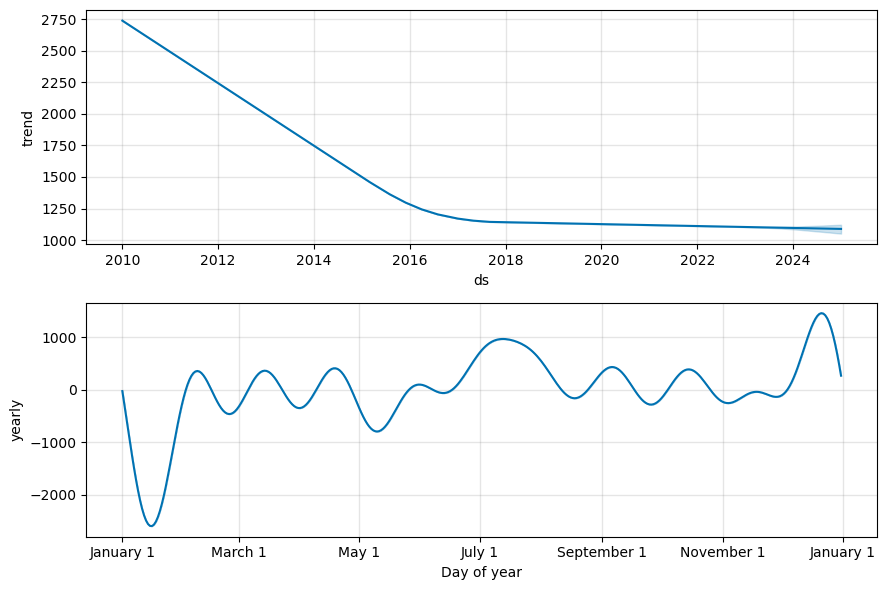

In [38]:
monthly_modelV1.plot_forecast_components()

Mean Absolute Error : 142.6662467528647
Mean Absolute Percentage Error : 3.929632897872399e+16
R^2 Score : 0.8173760554055484


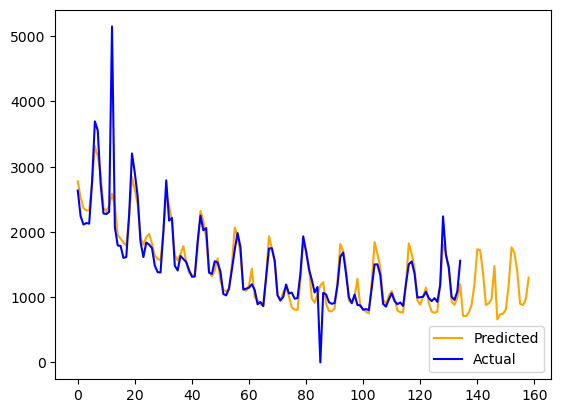

In [45]:
monthly_modelV1.evaluate_forecast( 24)

#### Forecast Yearly electricity consumption

In [46]:
yearly_df = pd.read_csv("../data/Yearly-EC.csv", usecols=["ds", "y"])

In [47]:
yearly_prophet = Prophet(yearly_seasonality=True)

In [48]:
yearly_modelV1 = TrainModel(yearly_df, "yearly", yearly_prophet)
yearly_modelV1.fit_model()
yearly_modelV1.get_forecast(time_period=2, freq='Y')

18:28:27 - cmdstanpy - INFO - Chain [1] start processing


18:28:27 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
yearly_modelV1.future.tail()

,ds
11,2021-01-01
12,2022-01-01
13,2023-01-01
14,2023-12-31
15,2024-12-31


In [50]:
yearly_modelV1.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11,2021-01-01,730.709872,-350.574089,1810.197277
12,2022-01-01,692.677223,-399.855045,1771.411420
13,2023-01-01,635.359987,-519.499078,1766.460223
14,2023-12-31,721.842252,-336.046405,1824.525137
15,2024-12-31,462.355574,-646.122356,1530.914204


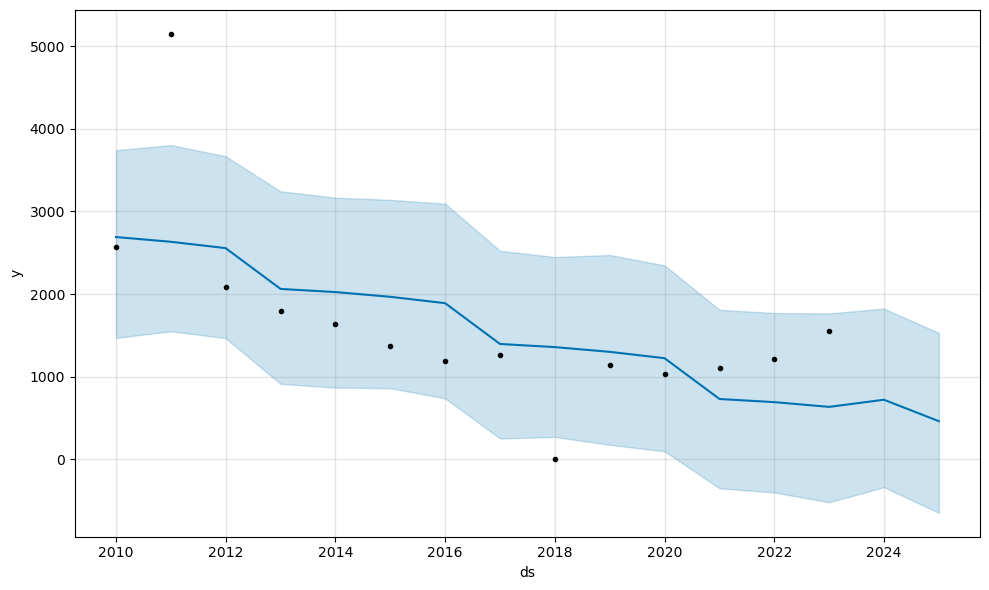

In [51]:
yearly_modelV1.plot_forecast()

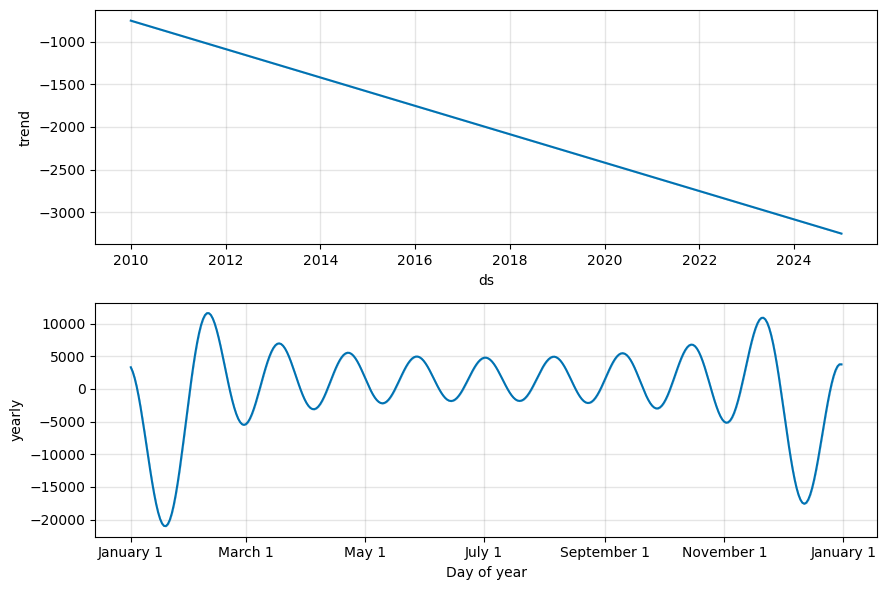

In [52]:
yearly_modelV1.plot_forecast_components()

Mean Absolute Error : 622.5521248052102
Mean Absolute Percentage Error : 4.370630795663793e+17
R^2 Score : 0.38563861141144473


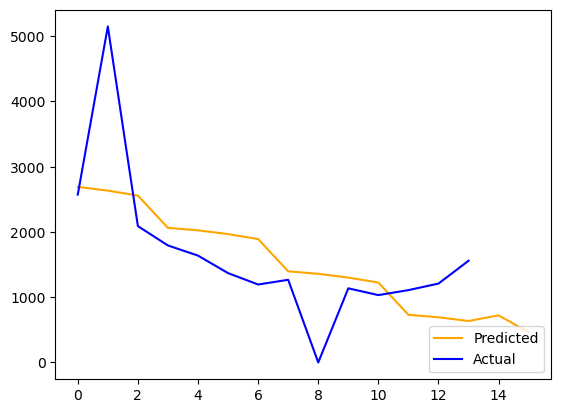

In [53]:
yearly_modelV1.evaluate_forecast(2)

## Tuning of facebook prophet

In [5]:
from prophet import Prophet

# Build and Tune the model without tuning script
class BuildTuneProphet():
    def __init__(self, growth, seasonality, model=Prophet):
        self.growth = growth
        self.seasonality = seasonality
        self.model = model
        
    # pass default values for initializing Prophet
    def initialize_model(self, 
                        growth="linear",
                        changepoints=None,
                        n_changepoints=25,
                        changepoint_range=0.8,
                        daily_seasonality="auto", 
                        weekly_seasonality="auto", 
                        yearly_seasonality="auto",
                        holidays=None,
                        seasonality_mode="additive",
                        seasonality_prior_scale=10.0,
                        holidays_prior_scale=10.0,
                        changepoint_prior_scale=0.05,
                        mcmc_samples=0,
                        interval_width=0.8,
                        uncertainty_samples=1000,
                        stan_backend="CMDSTANPY"):
        self.model = Prophet(
                        growth=growth,
                        changepoints=changepoints,
                        n_changepoints=n_changepoints,
                        changepoint_range=changepoint_range,
                        daily_seasonality=daily_seasonality, 
                        weekly_seasonality=weekly_seasonality, 
                        yearly_seasonality=yearly_seasonality,
                        holidays=holidays,
                        seasonality_mode=seasonality_mode,
                        seasonality_prior_scale=seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale,
                        changepoint_prior_scale=changepoint_prior_scale,
                        mcmc_samples=mcmc_samples,
                        interval_width=interval_width,
                        uncertainty_samples=uncertainty_samples,
                        stan_backend=stan_backend
                    )
    
    # Tune by seasonality
    def add_seasonality(self, period, fourier_order,  name=None):
        if name == "daily":
            self.model.add_seasonality(name=name, period=period, fourier_order=fourier_order)
        elif name == "monthly":
            self.model.add_seasonality(name=name, period=period, fourier_order=fourier_order)
            
        elif name == "yearly":
            self.model.add_seasonality(name=name, period=period, fourier_order=fourier_order)
        else:
            print(f"Seasonality {name} is not supported.")

In [6]:
from sklearn.model_selection import train_test_split

def get_train_test(df):
    train_set, test_set = train_test_split(df, test_size=0.25, shuffle=False)
    return train_set, test_set

In [7]:
def get_max_capacity(df):
    return df['y'].max() * 1.6  # maximum in the column and a buffer of 60^

#### Daily tuned Prophet

##### Load daily dataset

In [8]:
train_daily_df, test_daily_df = get_train_test(pd.read_csv("../data/Daily-EC.csv", usecols=["ds","y"]))
train_daily_df.shape, test_daily_df.shape

((335339, 2), (111780, 2))

#### 100 days growth linear

In [22]:
daily_model_tuned = BuildTuneProphet(growth="linear", seasonality="daily")
daily_model_tuned.initialize_model(growth="linear", n_changepoints=30, changepoint_prior_scale=1)
daily_model_tuned.add_seasonality(name="daily", period=30.5, fourier_order=5)

In [36]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()
train_model_daily.get_forecast(time_period=100, freq="D")

19:28:19 - cmdstanpy - INFO - Chain [1] start processing
19:31:43 - cmdstanpy - INFO - Chain [1] done processing


##### predicted values

In [38]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,3504.063126,-966.755218,7988.428703
604,2023-05-02,3895.996124,-727.793747,8009.254226
605,2023-05-03,4608.978125,-31.197980,9203.359666
606,2023-05-04,5489.601739,1107.453829,9882.470919
607,2023-05-05,7024.662867,2328.436479,11523.815314
608,2023-05-06,14252.863754,9855.219686,18817.526772
609,2023-05-07,13955.823601,9466.726769,18648.001066
610,2023-05-08,8689.387956,3808.868661,13261.919673
611,2023-05-09,6574.620491,2087.471690,11448.714136
612,2023-05-10,3920.382533,-734.714473,8582.423118


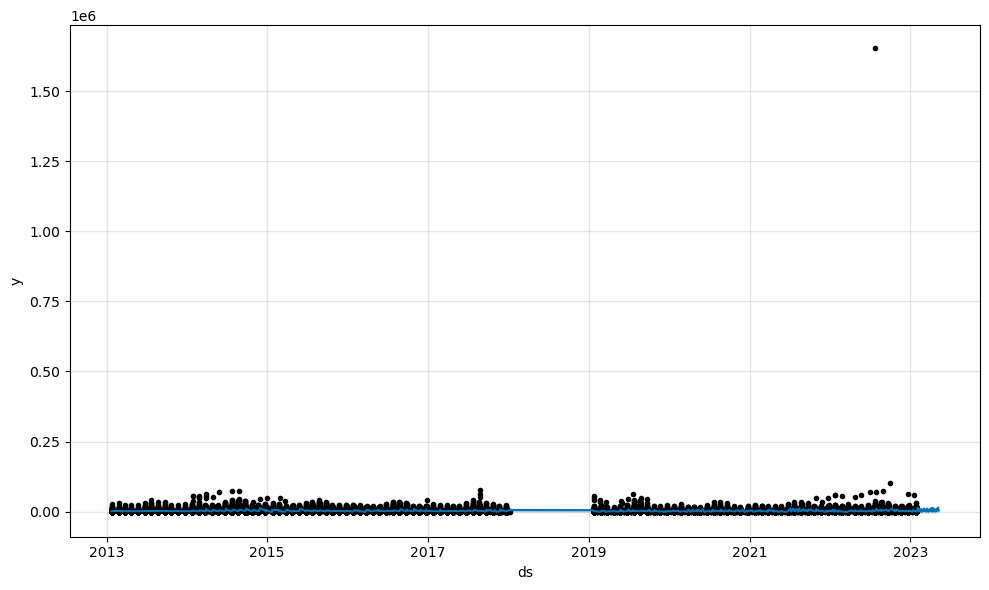

In [39]:
train_model_daily.plot_forecast()

Mean Absolute Error : 3184.5495900322458
Mean Absolute Percentage Error : 5.970922516243019e+18
R^2 Score : -0.5581310438653471


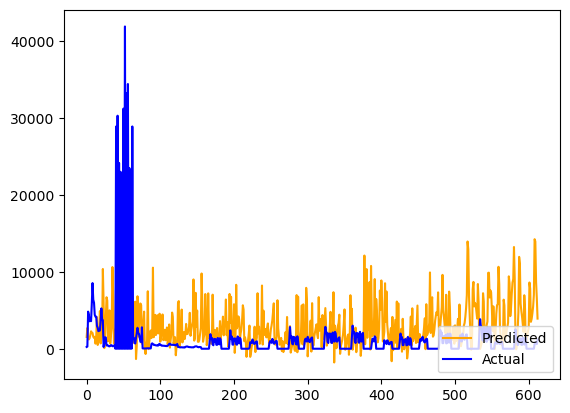

In [40]:
train_model_daily.evaluate_daily()

##### 100 days growth Logistic

In [61]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=1)
daily_model_tuned.add_seasonality(name="daily", period=30.5, fourier_order=5)

In [62]:
# For logistic growth always add a capacity column to the dataset
capacity = 10000
df_with_cap = train_daily_df.copy()
df_with_cap["cap"] = get_max_capacity(df_with_cap)

train_model_daily = TrainModel(df_with_cap, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

20:06:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:07 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="logistic", cap=capacity)

In [65]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,1477.366033,-3573.887219,5730.588215
604,2023-05-02,1509.047570,-2920.555819,5770.104245
605,2023-05-03,1702.562145,-2851.976305,5831.121252
606,2023-05-04,2234.688612,-2559.381406,6612.839914
607,2023-05-05,3440.999445,-1146.929405,7995.049852
608,2023-05-06,5159.131320,747.083756,9636.915822
609,2023-05-07,6420.129374,2191.953185,11046.990130
610,2023-05-08,4451.695928,126.420172,9246.729886
611,2023-05-09,1887.188690,-2446.440227,6459.106449
612,2023-05-10,-736.696308,-4946.289571,3607.034755


Mean Absolute Error : 2288.34898600618
Mean Absolute Percentage Error : 3.586708132699887e+18
R^2 Score : -0.18728031350345353


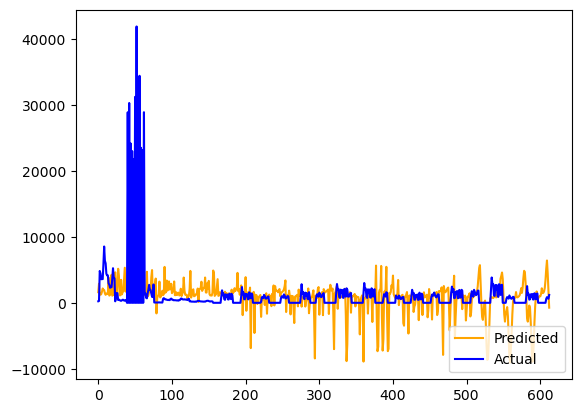

In [66]:
train_model_daily.evaluate_daily()

##### 100 days growth Flat

In [9]:
daily_model_tuned = BuildTuneProphet(growth="flat", seasonality="daily")
daily_model_tuned.initialize_model(growth="flat", n_changepoints=30, changepoint_prior_scale=1)
daily_model_tuned.add_seasonality(name="daily", period=30.5, fourier_order=5)

In [15]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

20:24:10 - cmdstanpy - INFO - Chain [1] start processing
20:24:45 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="flat")

In [17]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,1436.100913,-2994.803188,6050.106471
604,2023-05-02,1472.808893,-3172.904291,5879.006235
605,2023-05-03,1654.686840,-2724.887560,6401.817900
606,2023-05-04,2172.035944,-2279.989808,6679.630119
607,2023-05-05,3529.471044,-1139.194767,8233.924671
608,2023-05-06,11064.674601,6513.499443,15337.413920
609,2023-05-07,12084.427837,7452.806992,16573.361524
610,2023-05-08,7502.031572,2819.998389,11976.856184
611,2023-05-09,5866.655397,1016.732571,10406.852578
612,2023-05-10,3139.242187,-1529.075030,7683.980002


Mean Absolute Error : 2748.0720469293096
Mean Absolute Percentage Error : 5.062198287662611e+18
R^2 Score : -0.36413378794890106


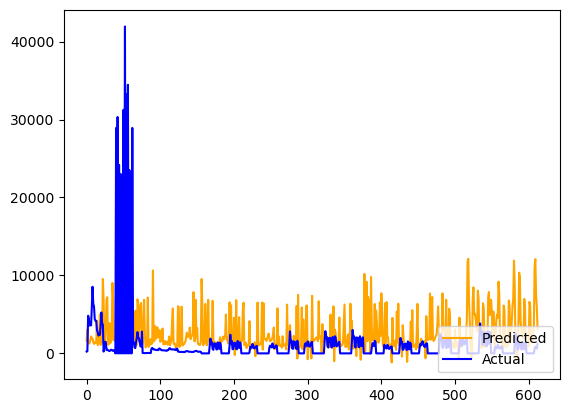

In [18]:
train_model_daily.evaluate_daily()

Logistic growth is giving the best performance tuning other parameters lets try fourier_order of 10 the default parameter

In [19]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=1)
daily_model_tuned.add_seasonality(name="daily", period=30.5, fourier_order=10)

In [20]:
# For logistic growth always add a capacity column to the dataset
capacity = 10000
train_daily_df["cap"] = get_max_capacity(train_daily_df)


In [21]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

20:32:12 - cmdstanpy - INFO - Chain [1] start processing
20:34:30 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="logistic", cap=capacity)

In [23]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,1339.349941,-3162.807549,5931.697845
604,2023-05-02,1427.819437,-2965.753643,6019.853059
605,2023-05-03,1719.773017,-2599.180336,6083.669235
606,2023-05-04,1787.405570,-2695.382851,6719.310949
607,2023-05-05,3184.014564,-1465.230361,7596.128223
608,2023-05-06,8256.107268,3782.029226,12803.426514
609,2023-05-07,10430.044788,6422.939366,15142.363808
610,2023-05-08,2964.871630,-1529.196430,8062.083418
611,2023-05-09,-5690.536040,-10196.629709,-961.481507
612,2023-05-10,-4625.895302,-9044.203293,-339.519097


Mean Absolute Error : 2601.7449351876576
Mean Absolute Percentage Error : 4.32103760596942e+18
R^2 Score : -0.3595042040409633


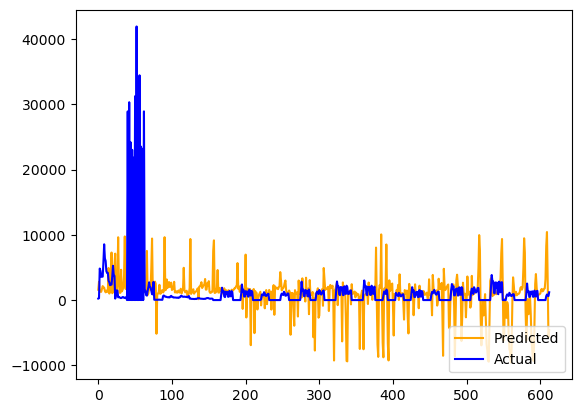

In [24]:
train_model_daily.evaluate_daily()

In [38]:
# try with period of 20.5 and fourier order of 7
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=1)
daily_model_tuned.add_seasonality(name="daily", period=33, fourier_order=7)

In [39]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_daily_df)
train_daily_df["cap"] = get_max_capacity(train_daily_df)

In [40]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

20:49:35 - cmdstanpy - INFO - Chain [1] start processing
20:50:23 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="logistic", cap=capacity)

In [42]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,803.282983,-3931.440197,5468.938441
604,2023-05-02,779.076623,-3512.242083,5159.470661
605,2023-05-03,888.783737,-3830.898614,5444.586909
606,2023-05-04,772.016955,-3616.860444,5253.172054
607,2023-05-05,647.875735,-4104.822702,4912.082560
608,2023-05-06,-4627.095925,-9421.455873,190.700545
609,2023-05-07,-2382.618703,-6859.722433,2265.315923
610,2023-05-08,1063.384410,-3222.167207,5614.409740
611,2023-05-09,899.043558,-3524.846623,5396.974013
612,2023-05-10,902.622910,-3694.975043,5439.708286


Mean Absolute Error : 1815.736632515772
Mean Absolute Percentage Error : 2.707448862118006e+18
R^2 Score : -0.15187594368405355


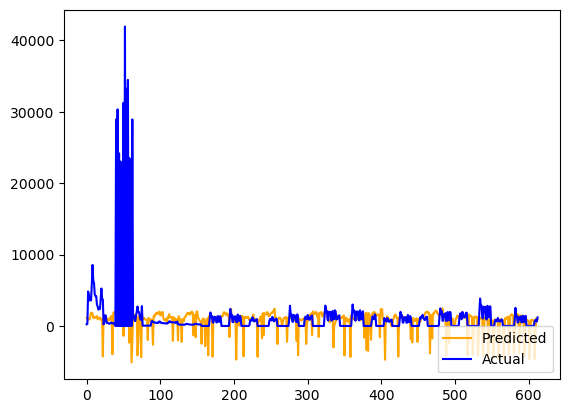

In [43]:
train_model_daily.evaluate_daily()

fourier_order of 7 and period of 33 the best so far

In [58]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic",) # other parameters default
daily_model_tuned.add_seasonality(name="daily", period=33, fourier_order=10)

In [59]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_daily_df)
train_daily_df["cap"] = get_max_capacity(train_daily_df)

In [60]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

21:03:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="logistic", cap=capacity)

In [62]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,636.816778,-3723.937132,5523.023242
604,2023-05-02,683.043274,-3789.062719,5403.584392
605,2023-05-03,880.464480,-3448.157597,5800.947963
606,2023-05-04,620.883869,-3913.568324,5339.696415
607,2023-05-05,362.365873,-4056.411223,4931.369979
608,2023-05-06,-4667.183494,-9136.812085,204.459073
609,2023-05-07,-2575.488877,-6835.428287,2378.523582
610,2023-05-08,882.503590,-3553.076922,5488.848448
611,2023-05-09,636.449659,-3991.732368,5116.243956
612,2023-05-10,751.508913,-3816.496141,5714.580035


Mean Absolute Error : 1813.3121554362604
Mean Absolute Percentage Error : 2.683712043710808e+18
R^2 Score : -0.1501417843004671


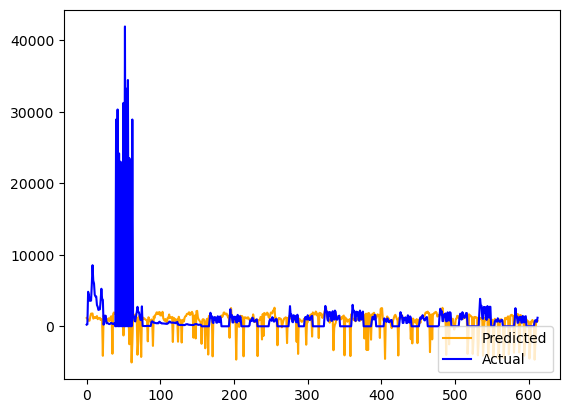

In [63]:
train_model_daily.evaluate_daily()

Try tuning on change points

In [64]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.5) # other parameters default
daily_model_tuned.add_seasonality(name="daily", period=33, fourier_order=10)

In [65]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_daily_df)
train_daily_df["cap"] = get_max_capacity(train_daily_df)

train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

21:12:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:01 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="logistic", cap=capacity)

In [67]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,641.203219,-4024.851157,5416.068030
604,2023-05-02,688.742994,-4183.794661,5353.490380
605,2023-05-03,886.339956,-3900.997136,5009.175066
606,2023-05-04,626.047047,-3923.933771,5349.195652
607,2023-05-05,369.608665,-4244.789346,5161.561855
608,2023-05-06,-4684.056370,-8950.718503,-510.643487
609,2023-05-07,-2532.113081,-7203.176278,1848.543891
610,2023-05-08,889.681803,-3439.858240,5152.640575
611,2023-05-09,645.415484,-3408.938236,5204.402771
612,2023-05-10,759.720534,-3909.616908,5420.929396


Mean Absolute Error : 1809.2617964947249
Mean Absolute Percentage Error : 2.675884349168092e+18
R^2 Score : -0.14858648018933818


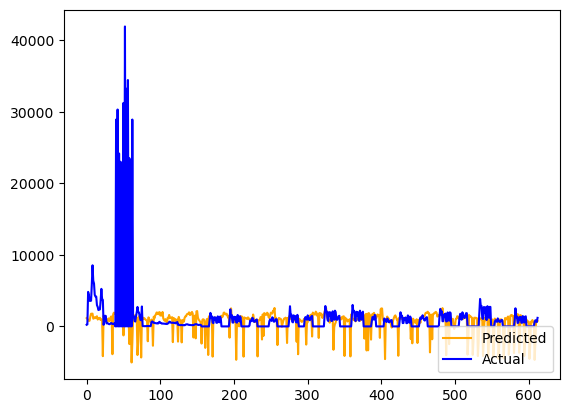

In [68]:
train_model_daily.evaluate_daily()

In [84]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
daily_model_tuned.add_seasonality(name="daily", period=33, fourier_order=10)

In [85]:

# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_daily_df)
train_daily_df["cap"] = get_max_capacity(train_daily_df)

train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

21:34:45 - cmdstanpy - INFO - Chain [1] start processing
21:36:06 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
train_model_daily.get_forecast(time_period=100, freq="D", growth="logistic", cap=capacity)

In [87]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
603,2023-05-01,629.771020,-3949.438920,5191.867983
604,2023-05-02,676.443316,-3568.345244,5410.133047
605,2023-05-03,872.282612,-3674.988811,5514.250182
606,2023-05-04,611.014894,-3851.237746,4873.403176
607,2023-05-05,352.921490,-4174.873223,4979.104194
608,2023-05-06,-4810.382820,-9498.610225,152.417934
609,2023-05-07,-2445.268506,-6917.438861,2171.753515
610,2023-05-08,870.848648,-3839.459425,5581.797500
611,2023-05-09,626.427584,-3953.448504,5171.673410
612,2023-05-10,740.909121,-3506.870357,5623.968974


Mean Absolute Error : 1807.5091849003506
Mean Absolute Percentage Error : 2.674992749640746e+18
R^2 Score : -0.1479540769551999


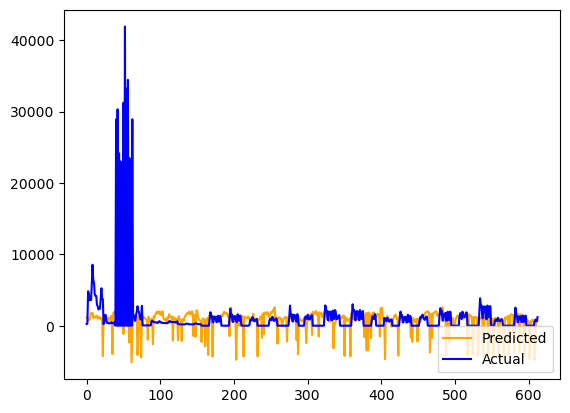

In [88]:
train_model_daily.evaluate_daily()

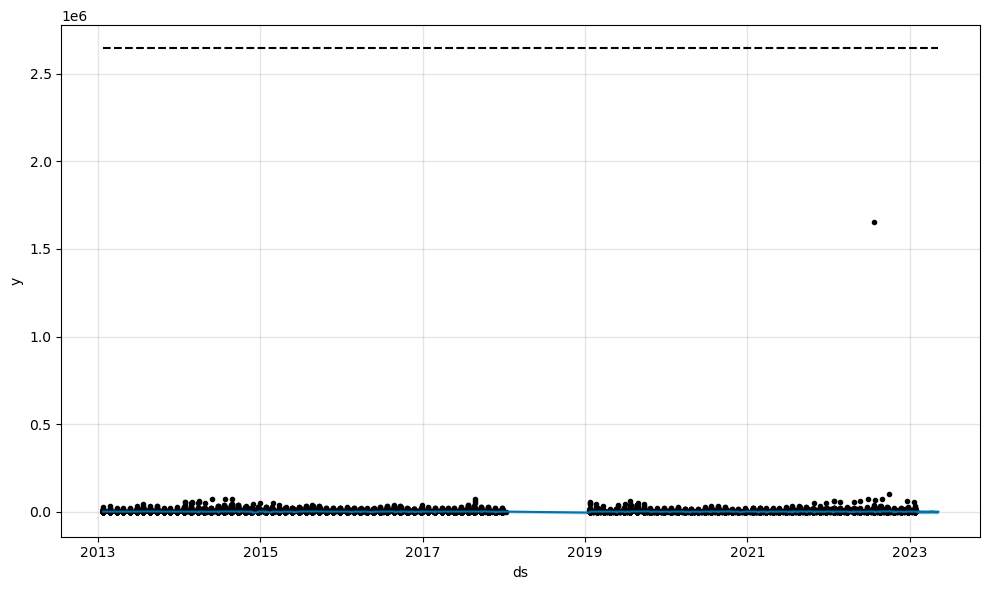

In [89]:
train_model_daily.plot_forecast()

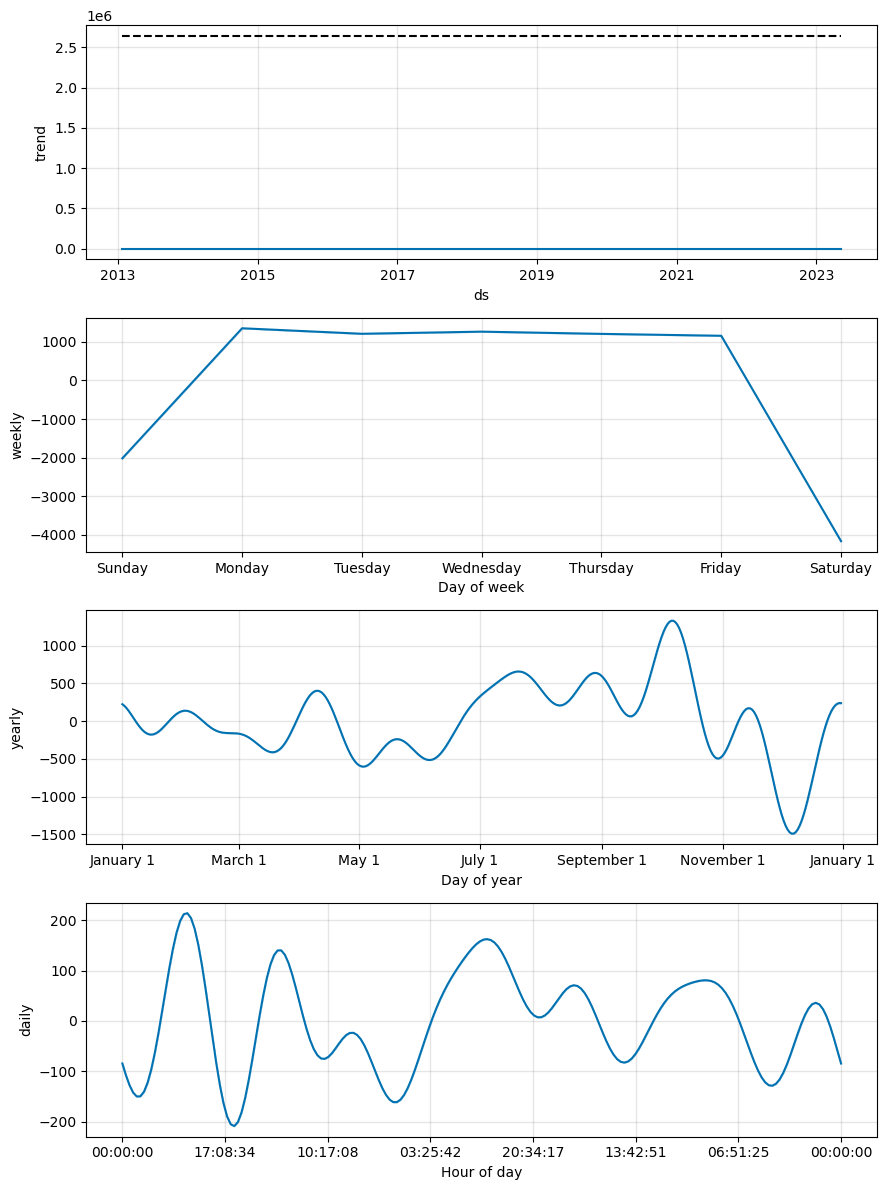

In [90]:
train_model_daily.plot_forecast_components()

#### 200 days growth logistic

In [75]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
daily_model_tuned.add_seasonality(name="daily", period=33, fourier_order=10)

In [76]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_daily_df)
train_daily_df["cap"] = get_max_capacity(train_daily_df)

In [77]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
train_model_daily.get_forecast(time_period=200, freq="D", growth="logistic", cap=capacity)

In [79]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
703,2023-08-09,1545.964487,-2963.390398,5813.014379
704,2023-08-10,1628.086729,-3032.939756,6137.930516
705,2023-08-11,1371.855096,-3000.296111,6105.708857
706,2023-08-12,-4156.748014,-8731.371266,204.326631
707,2023-08-13,-1866.040629,-6477.621819,2758.439079
708,2023-08-14,1715.746666,-2728.839845,6241.857706
709,2023-08-15,1519.614937,-3377.239710,5695.110264
710,2023-08-16,1469.524445,-3217.589344,5882.850584
711,2023-08-17,1470.189545,-3203.177605,5969.038337
712,2023-08-18,1455.981871,-3163.296260,5835.399644


Mean Absolute Error : 1849.1394813494546
Mean Absolute Percentage Error : 2.1247058483548196e+18
R^2 Score : -0.19707919113899797


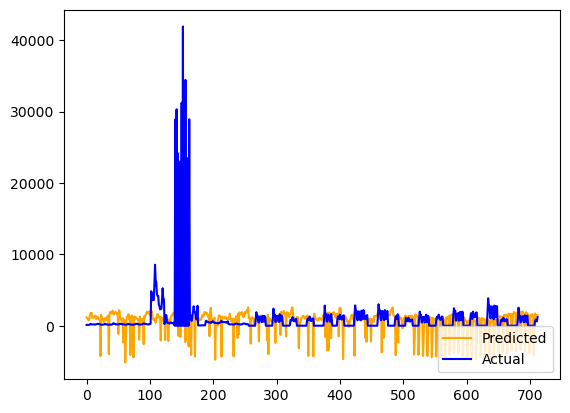

In [80]:
train_model_daily.evaluate_daily()

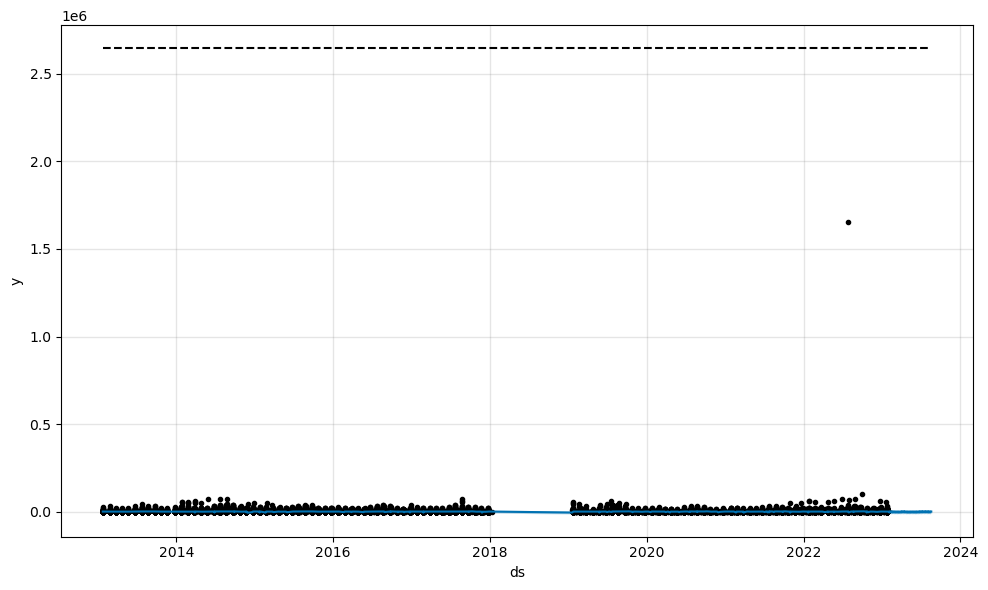

In [81]:
train_model_daily.plot_forecast()

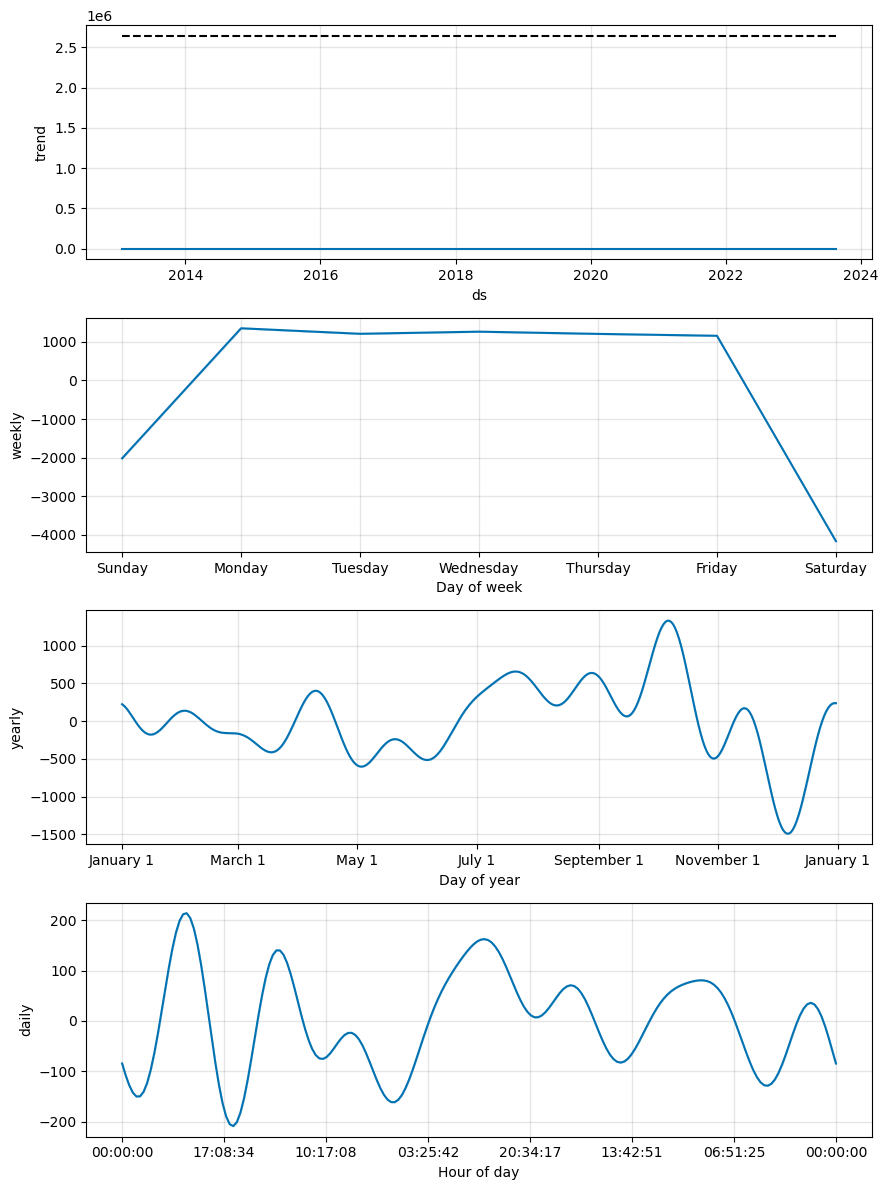

In [83]:
train_model_daily.plot_forecast_components()

#### 365 days growth logistic

In [91]:
daily_model_tuned = BuildTuneProphet(growth="logistic", seasonality="daily")
daily_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
daily_model_tuned.add_seasonality(name="daily", period=33, fourier_order=10)

In [92]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_daily_df)
train_daily_df["cap"] = get_max_capacity(train_daily_df)

In [93]:
train_model_daily = TrainModel(train_daily_df, "daily", daily_model_tuned.model)
train_model_daily.fit_model()

21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
train_model_daily.get_forecast(time_period=365, freq="D", growth="logistic", cap=capacity)

In [95]:
train_model_daily.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
868,2024-01-21,-2071.739453,-6554.793497,2531.825213
869,2024-01-22,1467.019712,-2815.377943,6254.969210
870,2024-01-23,1147.710489,-3891.470315,5297.293406
871,2024-01-24,1014.909843,-3709.276013,5867.051614
872,2024-01-25,1124.496116,-3725.151890,5269.227343
873,2024-01-26,1305.473890,-3086.649308,5996.881161
874,2024-01-27,-4056.485124,-8176.154568,408.448850
875,2024-01-28,-2018.085315,-6637.781793,2501.138947
876,2024-01-29,1397.633630,-3370.599046,5331.455769
877,2024-01-30,1275.035403,-3217.918048,5753.633278


Mean Absolute Error : 1958.1517755434202
Mean Absolute Percentage Error : 2.127205295896468e+18
R^2 Score : -0.2381670133692284


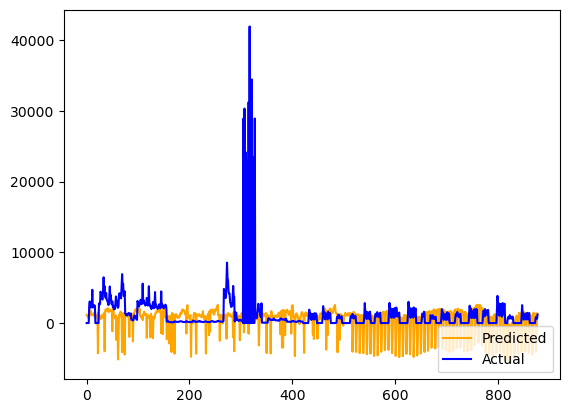

In [96]:
train_model_daily.evaluate_daily()

#### Monthly tuned Prophet

##### Load monthly dataset

In [8]:
train_monthly_df, test_monthly_df = get_train_test(pd.read_csv("../data/Monthly-EC.csv", usecols=["ds","y"]))
train_monthly_df.shape, test_monthly_df.shape

((101, 2), (34, 2))

##### 1 Month

In [126]:
monthly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="monthly")
monthly_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
monthly_model_tuned.add_seasonality(name="monthly", period=33, fourier_order=10)

In [127]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_monthly_df)
train_monthly_df["cap"] = get_max_capacity(train_monthly_df)

In [128]:

train_model_monthly = TrainModel(train_monthly_df, "monthly", monthly_model_tuned.model)
train_model_monthly.fit_model()

train_model_monthly.get_forecast(time_period=1, freq="M", growth="logistic", cap=capacity)

22:08:37 - cmdstanpy - INFO - Chain [1] start processing
22:08:37 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
train_model_monthly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
92,2019-07-01,1807.921493,1440.985754,2165.826261
93,2019-08-01,1783.608419,1402.003864,2158.174673
94,2019-09-01,1286.446658,914.964882,1662.646112
95,2019-10-01,724.732431,355.100317,1093.916409
96,2019-11-01,805.164325,443.923642,1161.842369
97,2019-12-01,962.714313,557.663632,1314.049455
98,2020-01-01,932.060154,554.142357,1297.472482
99,2020-02-01,671.478267,307.062206,1033.312013
100,2020-03-01,747.701812,386.499861,1106.458297
101,2020-03-31,270.555171,-92.092688,664.691213


Mean Absolute Error : 174.43508319656607
Mean Absolute Percentage Error : 4.0378329370946536e+16
R^2 Score : 0.8397559016094511


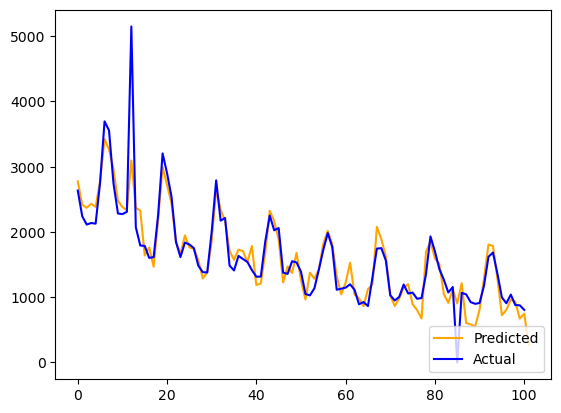

In [130]:
train_model_monthly.evaluate_forecast(1)

Tuning monthly model

In [131]:
monthly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="monthly")
monthly_model_tuned.initialize_model(growth="logistic", changepoint_prior_scale=0.25) # other parameters default
monthly_model_tuned.add_seasonality(name="monthly", period=30.5, fourier_order=10)

In [132]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_monthly_df)
train_monthly_df["cap"] = get_max_capacity(train_monthly_df)

In [133]:
train_model_monthly = TrainModel(train_monthly_df, "monthly", monthly_model_tuned.model)
train_model_monthly.fit_model()

22:08:40 - cmdstanpy - INFO - Chain [1] start processing
22:08:40 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
train_model_monthly.get_forecast(time_period=1, freq="M", growth="logistic", cap=capacity)


In [135]:
train_model_monthly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
92,2019-07-01,1813.717258,1444.157250,2198.122969
93,2019-08-01,1730.715483,1355.694569,2096.044788
94,2019-09-01,1405.091438,1017.697282,1781.528534
95,2019-10-01,908.341401,535.832512,1264.138231
96,2019-11-01,838.229925,463.403797,1229.370207
97,2019-12-01,923.863948,554.121520,1296.312834
98,2020-01-01,1218.673705,853.110935,1614.290782
99,2020-02-01,814.384773,449.509660,1178.923080
100,2020-03-01,791.850359,408.702920,1158.299106
101,2020-03-31,1122.831814,782.519758,1472.977621


Mean Absolute Error : 157.36863032187966
Mean Absolute Percentage Error : 4.123950094151271e+16
R^2 Score : 0.8350227420256493


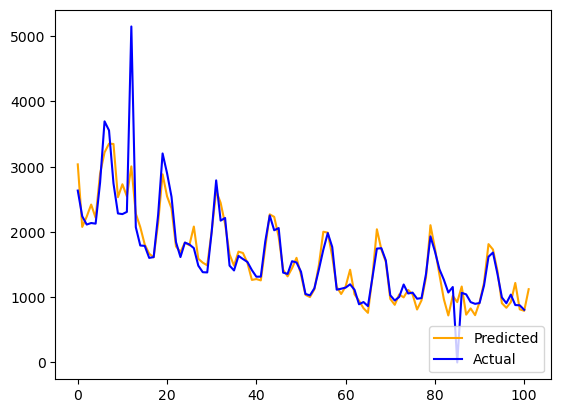

In [136]:
train_model_monthly.evaluate_forecast(1)

A deviation of 157KWH

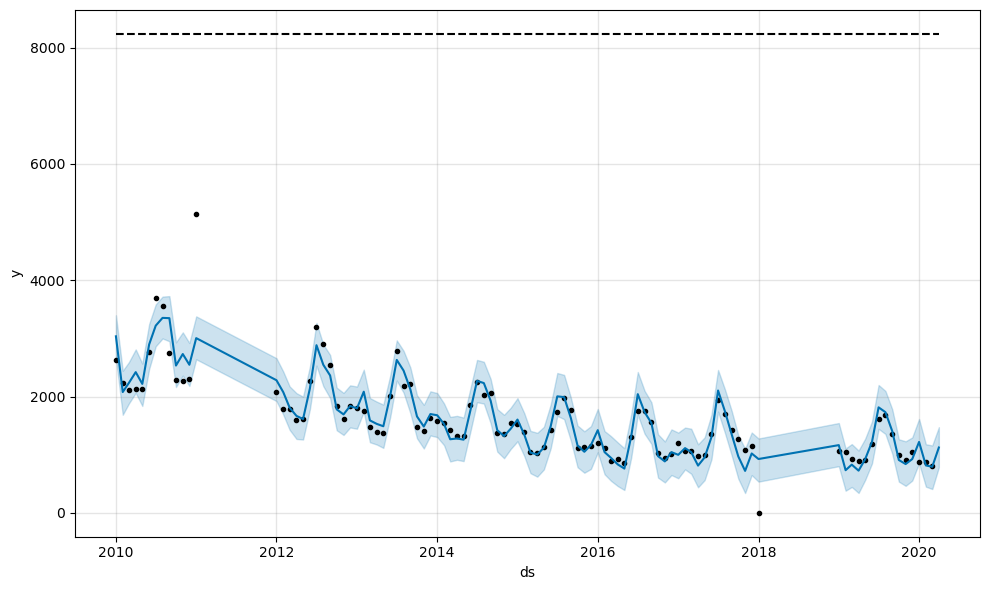

In [137]:
train_model_monthly.plot_forecast()

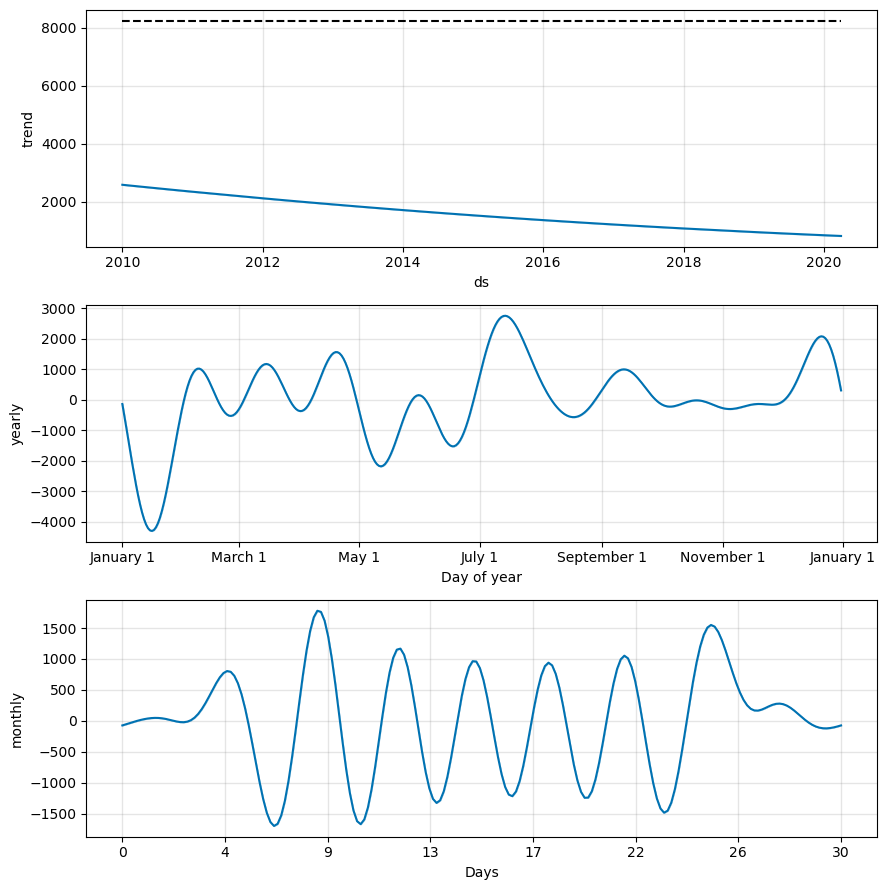

In [138]:
train_model_monthly.plot_forecast_components()

##### 6 Months

In [139]:
monthly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="monthly")
monthly_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.5) # other parameters default
monthly_model_tuned.add_seasonality(name="monthly", period=33, fourier_order=7)

In [140]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_monthly_df)
train_monthly_df["cap"] = get_max_capacity(train_monthly_df)

In [141]:
train_model_monthly = TrainModel(train_monthly_df, "monthly", monthly_model_tuned.model)
train_model_monthly.fit_model()

22:08:47 - cmdstanpy - INFO - Chain [1] start processing
22:08:47 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
# forecast 6 months
train_model_monthly.get_forecast(time_period=6, freq="M", growth="logistic", cap=capacity)

In [143]:
train_model_monthly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
97,2019-12-01,953.594096,596.247186,1350.537691
98,2020-01-01,1099.681356,746.118024,1461.905346
99,2020-02-01,673.987550,308.894882,1052.107910
100,2020-03-01,783.464246,405.296316,1159.861474
101,2020-03-31,365.317896,-8.411141,723.031339
102,2020-04-30,1205.748199,863.598085,1575.600986
103,2020-05-31,1335.568474,973.849595,1684.337014
104,2020-06-30,1252.214552,887.753007,1635.794793
105,2020-07-31,1554.786954,1178.107330,1907.262969
106,2020-08-31,1846.481259,1480.580691,2238.194390


Mean Absolute Error : 172.38504056944197
Mean Absolute Percentage Error : 4.241579254784647e+16
R^2 Score : 0.8379711062519641


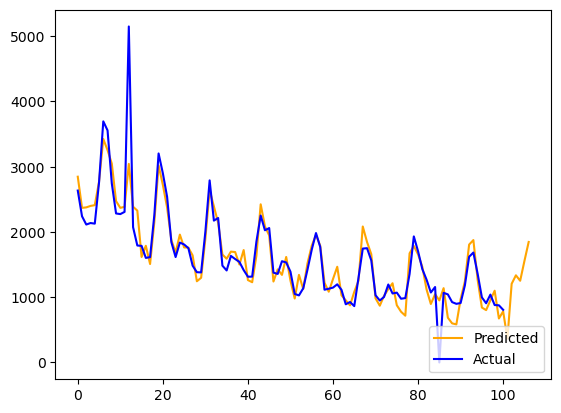

In [144]:
train_model_monthly.evaluate_forecast(6)

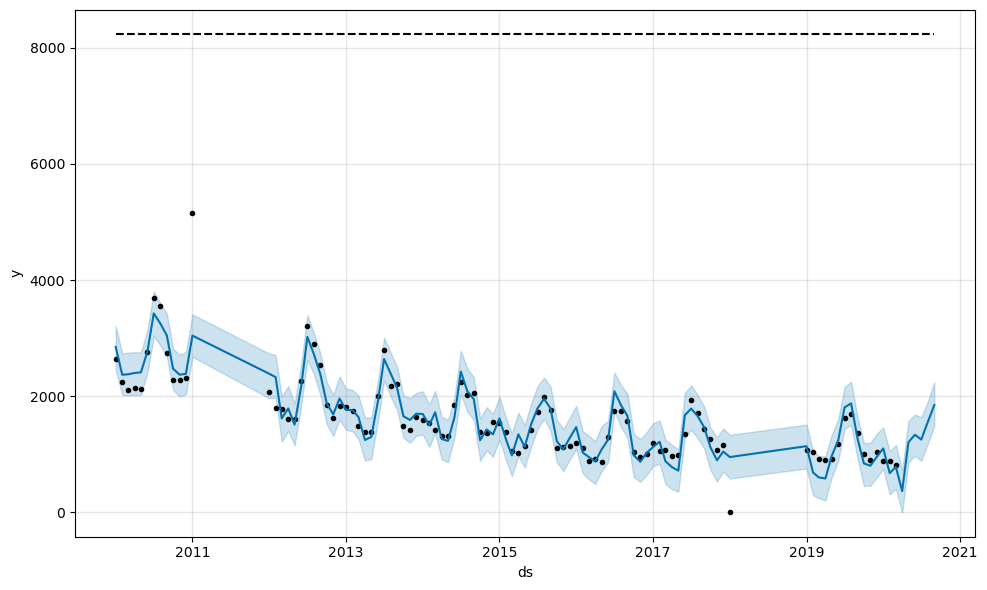

In [145]:
train_model_monthly.plot_forecast()

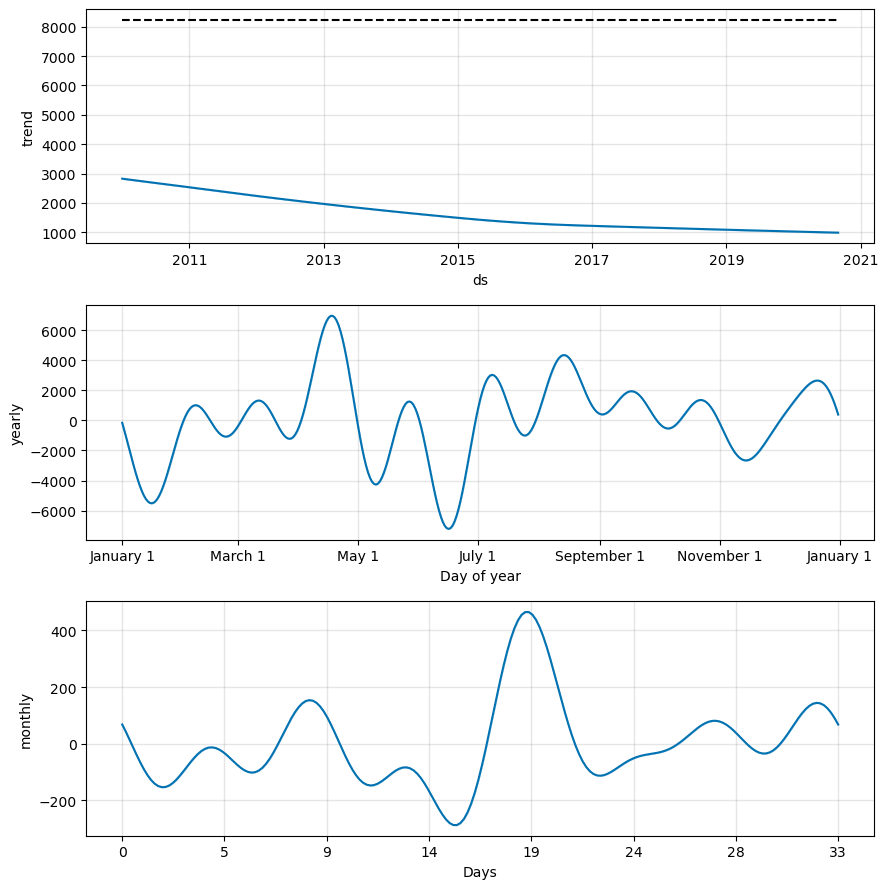

In [146]:
train_model_monthly.plot_forecast_components()

##### 9 Months

In [9]:
monthly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="monthly")
monthly_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.5) # other parameters default
monthly_model_tuned.add_seasonality(name="monthly", period=33, fourier_order=10)


In [10]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_monthly_df)
train_monthly_df["cap"] = get_max_capacity(train_monthly_df)

In [11]:
train_model_monthly = TrainModel(train_monthly_df, "monthly", monthly_model_tuned.model)
train_model_monthly.fit_model()

22:25:33 - cmdstanpy - INFO - Chain [1] start processing


22:25:33 - cmdstanpy - INFO - Chain [1] done processing


In [12]:

train_model_monthly.get_forecast(time_period=9, freq="M", growth="logistic", cap=capacity)

In [13]:
train_model_monthly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
100,2020-03-01,790.498791,427.640733,1132.055756
101,2020-03-31,302.026134,-65.463586,655.941631
102,2020-04-30,1541.731232,1168.551673,1899.202027
103,2020-05-31,1075.196860,666.360228,1427.222664
104,2020-06-30,1053.261479,718.517064,1413.977897
105,2020-07-31,1821.542706,1429.084717,2156.781726
106,2020-08-31,1724.553969,1360.737254,2069.135264
107,2020-09-30,630.009047,304.255958,1015.039710
108,2020-10-31,695.747111,346.792130,1028.713396
109,2020-11-30,759.254085,384.333099,1119.746101


Mean Absolute Error : 172.25948420837108
Mean Absolute Percentage Error : 4.0901836317469864e+16
R^2 Score : 0.8429024241173516


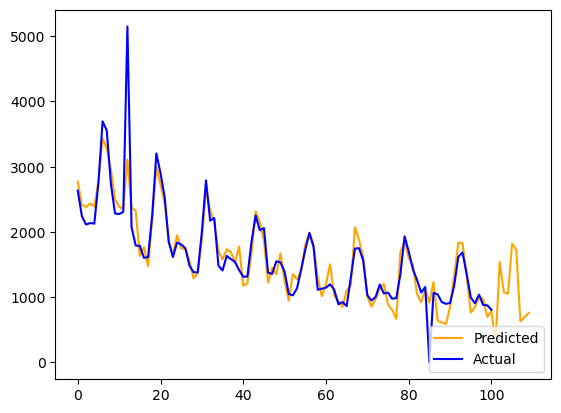

In [14]:
train_model_monthly.evaluate_forecast(9)

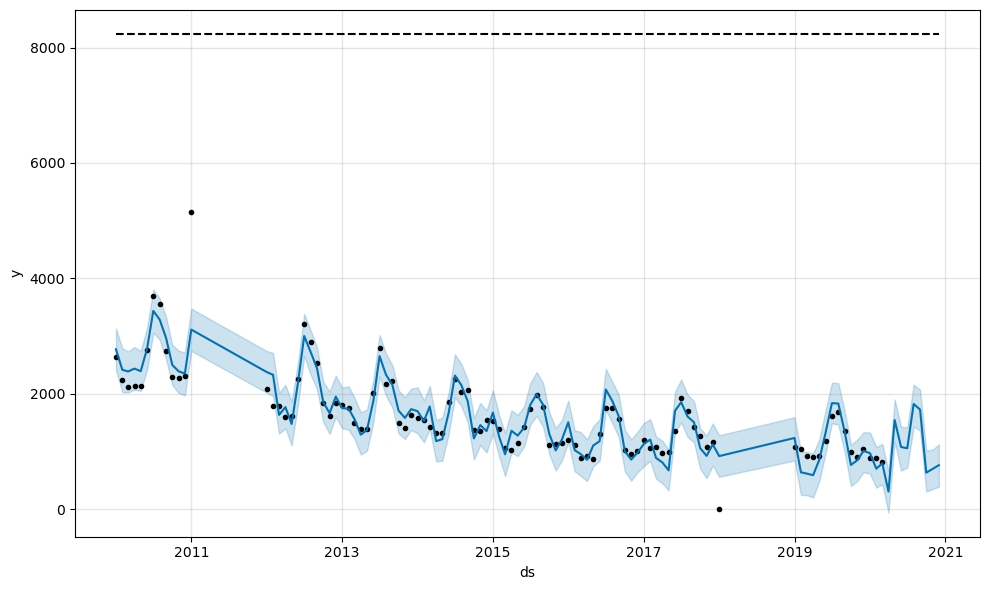

In [15]:
train_model_monthly.plot_forecast()

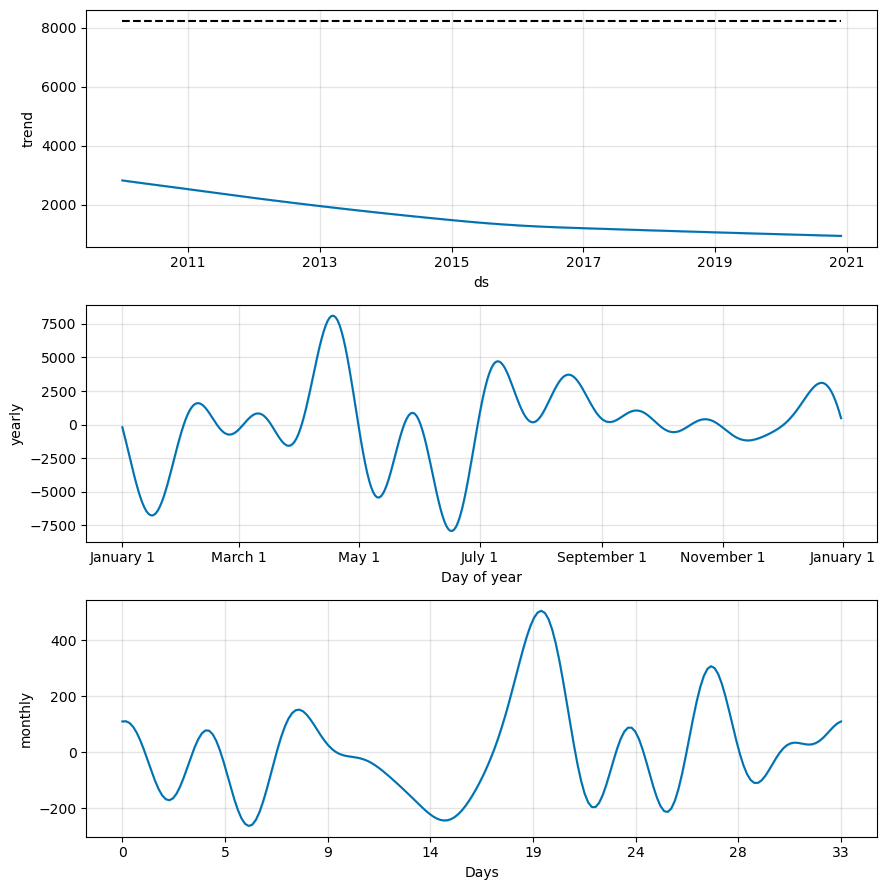

In [16]:
train_model_monthly.plot_forecast_components()

#### Yearly tuned Prophet

##### Load yearly data

In [17]:
train_yearly_df, test_yearly_df = get_train_test(pd.read_csv("../data/Yearly-EC.csv", usecols=["ds","y"]))
train_yearly_df.shape, test_yearly_df.shape

((10, 2), (4, 2))

##### 1 Year

In [16]:
yearly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="yearly")
yearly_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
yearly_model_tuned.add_seasonality(name="yearly", period=33, fourier_order=10)

In [17]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_yearly_df)
train_yearly_df["cap"] = get_max_capacity(train_yearly_df)


In [18]:
train_model_yearly = TrainModel(train_yearly_df, "yearly", yearly_model_tuned.model)
train_model_yearly.fit_model()

22:17:40 - cmdstanpy - INFO - Chain [1] start processing
22:17:43 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
train_model_yearly.get_forecast(time_period=1, freq="Y", growth="logistic", cap=capacity)

In [20]:
train_model_yearly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1,2011-01-01,5148.296499,5148.296496,5148.296501
2,2012-01-01,2088.902128,2088.902125,2088.902130
3,2013-01-01,1793.144244,1793.144241,1793.144246
4,2014-01-01,1637.182779,1637.182777,1637.182782
5,2015-01-01,1369.194889,1369.194887,1369.194892
6,2016-01-01,1194.658345,1194.658342,1194.658347
7,2017-01-01,1266.891403,1266.891401,1266.891406
8,2018-01-01,0.036979,0.036977,0.036982
9,2019-01-01,1136.204019,1136.204016,1136.204021
10,2019-12-31,41264.235752,41264.235749,41264.235754


Mean Absolute Error : 0.02688651898383796
Mean Absolute Percentage Error : 16653984834662.4
R^2 Score : 0.9999999992789322


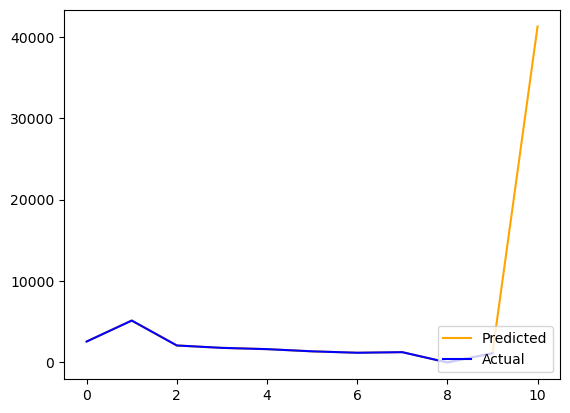

In [21]:
train_model_yearly.evaluate_forecast(1)

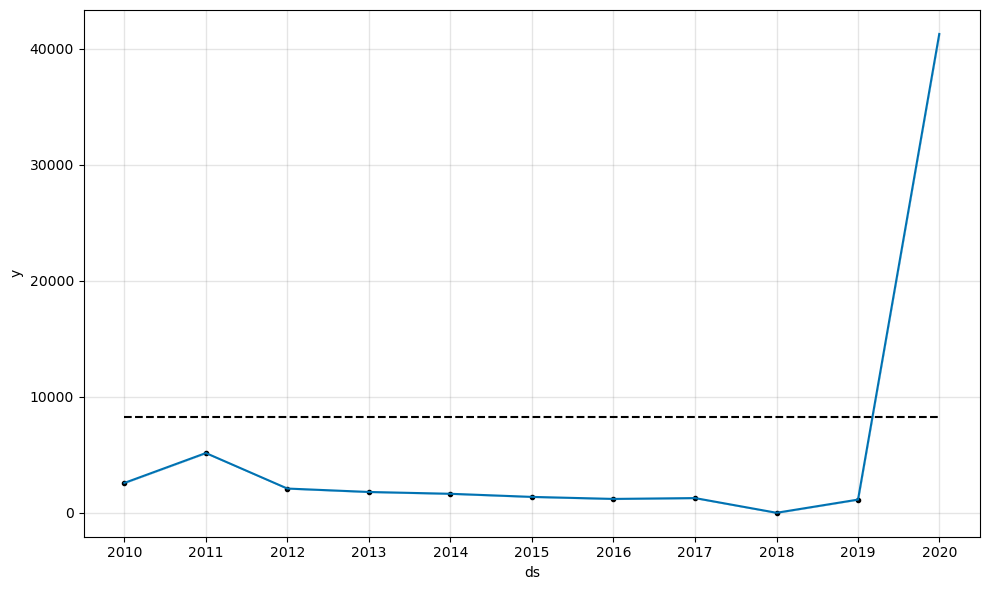

In [23]:
train_model_yearly.plot_forecast()

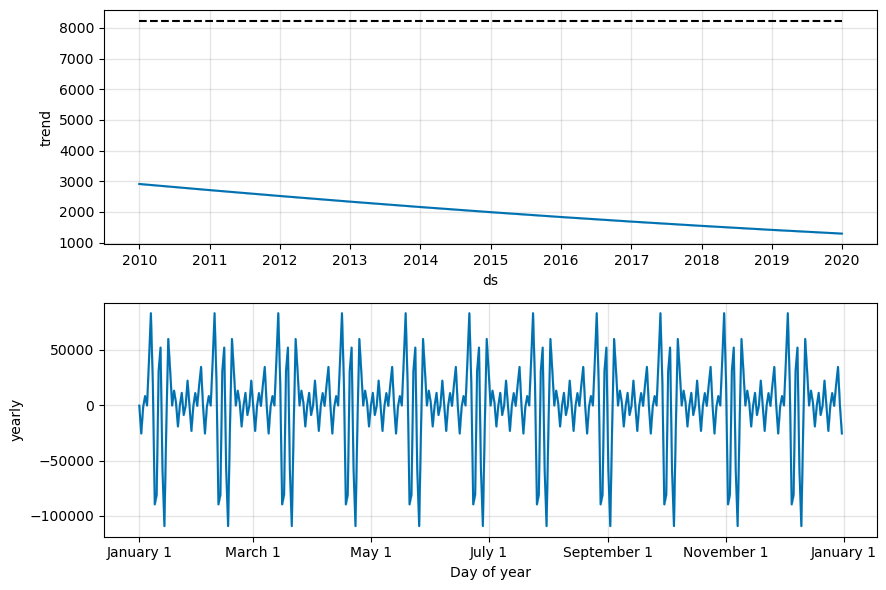

In [24]:

train_model_yearly.plot_forecast_components()

#####  10 Years

In [27]:
yearly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="yearly")
yearly_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
yearly_model_tuned.add_seasonality(name="yearly", period=33, fourier_order=10)


In [28]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_yearly_df)
train_yearly_df["cap"] = get_max_capacity(train_yearly_df)


In [29]:

train_model_yearly = TrainModel(train_yearly_df, "yearly", yearly_model_tuned.model)
train_model_yearly.fit_model()


22:28:00 - cmdstanpy - INFO - Chain [1] start processing


22:28:03 - cmdstanpy - INFO - Chain [1] done processing


In [30]:


train_model_yearly.get_forecast(time_period=10, freq="Y", growth="logistic", cap=capacity)


In [31]:
train_model_yearly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
10,2019-12-31,41264.235752,41264.235749,41264.235754
11,2020-12-31,-88404.716793,-88404.717645,-88404.715876
12,2021-12-31,31892.341140,31892.338397,31892.343814
13,2022-12-31,-57051.380836,-57051.385965,-57051.375737
14,2023-12-31,-16486.741970,-16486.749691,-16486.734368
15,2024-12-31,468.603862,468.593966,468.614218
16,2025-12-31,3168.469073,3168.456956,3168.481600
17,2026-12-31,232.277183,232.263106,232.291962
18,2027-12-31,-8306.218249,-8306.234169,-8306.201883
19,2028-12-31,20.624551,20.607692,20.642130


Mean Absolute Error : 0.02688651898383796
Mean Absolute Percentage Error : 16653984834662.4
R^2 Score : 0.9999999992789322


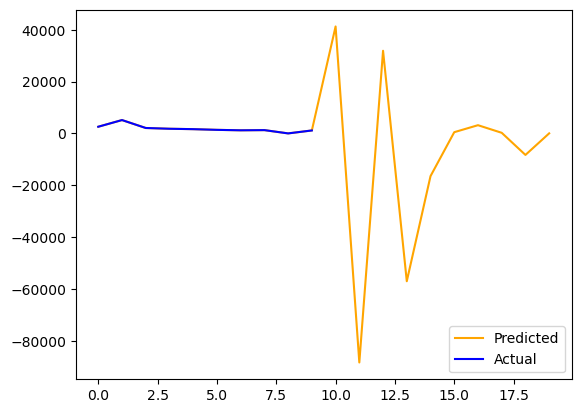

In [32]:
train_model_yearly.evaluate_forecast(10)

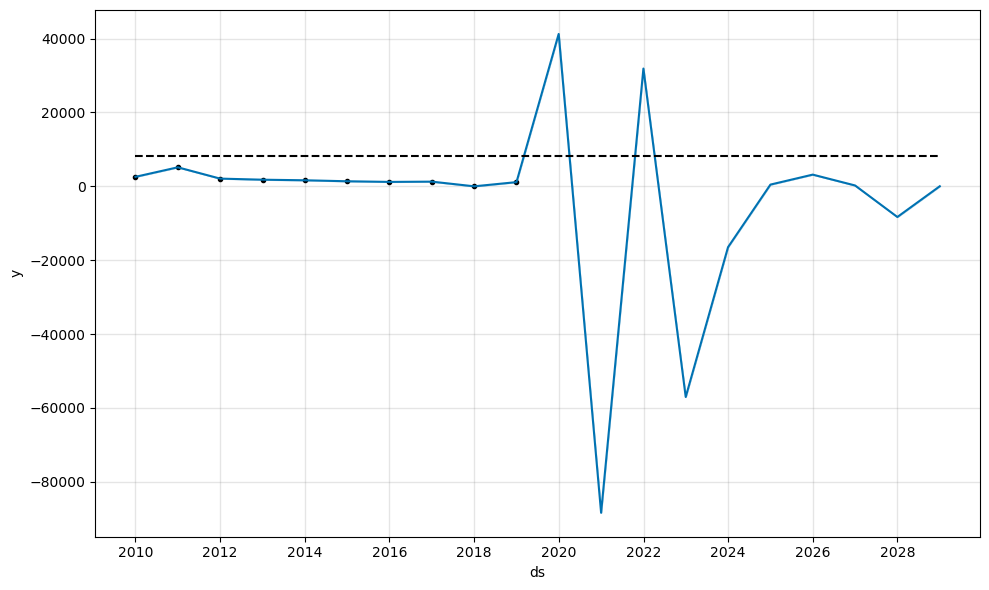

In [33]:
train_model_yearly.plot_forecast()

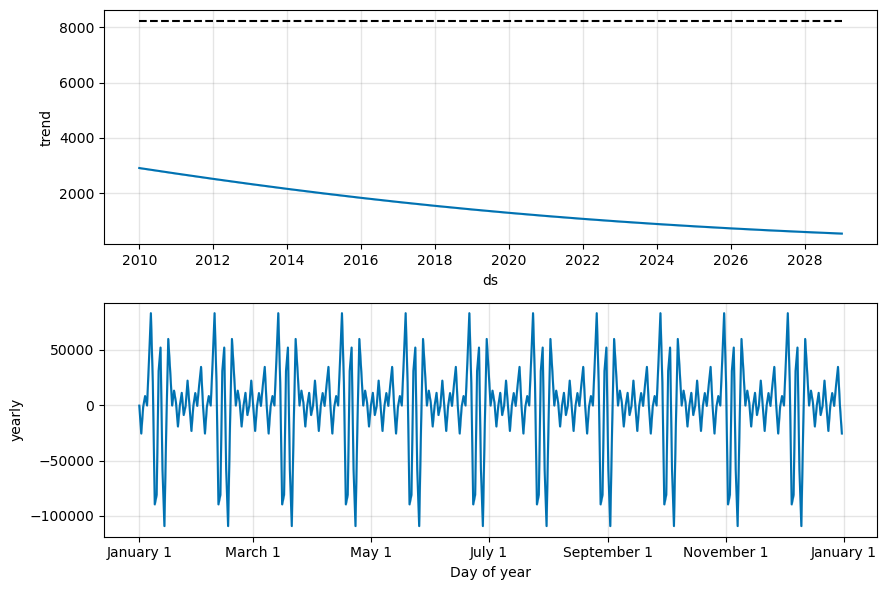

In [34]:
train_model_yearly.plot_forecast_components()

##### 20 years

In [35]:
yearly_model_tuned = BuildTuneProphet(growth="logistic", seasonality="yearly")
yearly_model_tuned.initialize_model(growth="logistic", n_changepoints=30, changepoint_prior_scale=0.25) # other parameters default
yearly_model_tuned.add_seasonality(name="yearly", period=33, fourier_order=10)

In [ ]:
# For logistic growth always add a capacity column to the dataset
capacity = get_max_capacity(train_yearly_df)
train_yearly_df["cap"] = get_max_capacity(train_yearly_df)

In [36]:
train_model_yearly = TrainModel(train_yearly_df, "yearly", yearly_model_tuned.model)
train_model_yearly.fit_model()


22:29:24 - cmdstanpy - INFO - Chain [1] start processing
22:29:27 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
train_model_yearly.get_forecast(time_period=20, freq="Y", growth="logistic", cap=capacity)

In [38]:
train_model_yearly.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
20,2029-12-31,-132.568653,-132.587998,-132.549898
21,2030-12-31,-196.599686,-196.619965,-196.579841
22,2031-12-31,34979.270909,34979.250085,34979.291493
23,2032-12-31,-1184.685454,-1184.706490,-1184.664755
24,2033-12-31,46.612094,46.591024,46.633312
25,2034-12-31,83379.177819,83379.156278,83379.199049
26,2035-12-31,-89320.737201,-89320.758832,-89320.716367
27,2036-12-31,52288.243395,52288.222421,52288.263875
28,2037-12-31,-108971.422158,-108971.442720,-108971.401559
29,2038-12-31,59999.634004,59999.613805,59999.654528


Mean Absolute Error : 0.02688651898383796
Mean Absolute Percentage Error : 16653984834662.4
R^2 Score : 0.9999999992789322


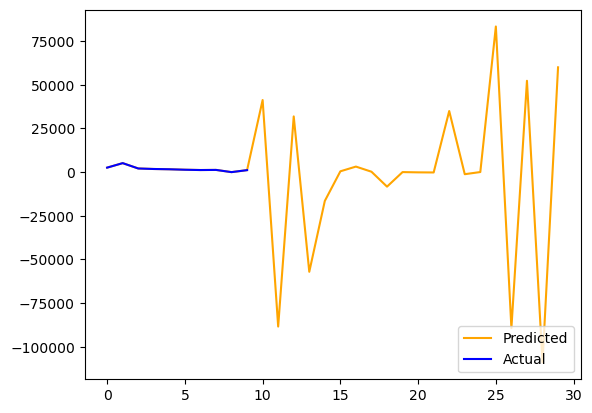

In [39]:
train_model_yearly.evaluate_forecast(20)

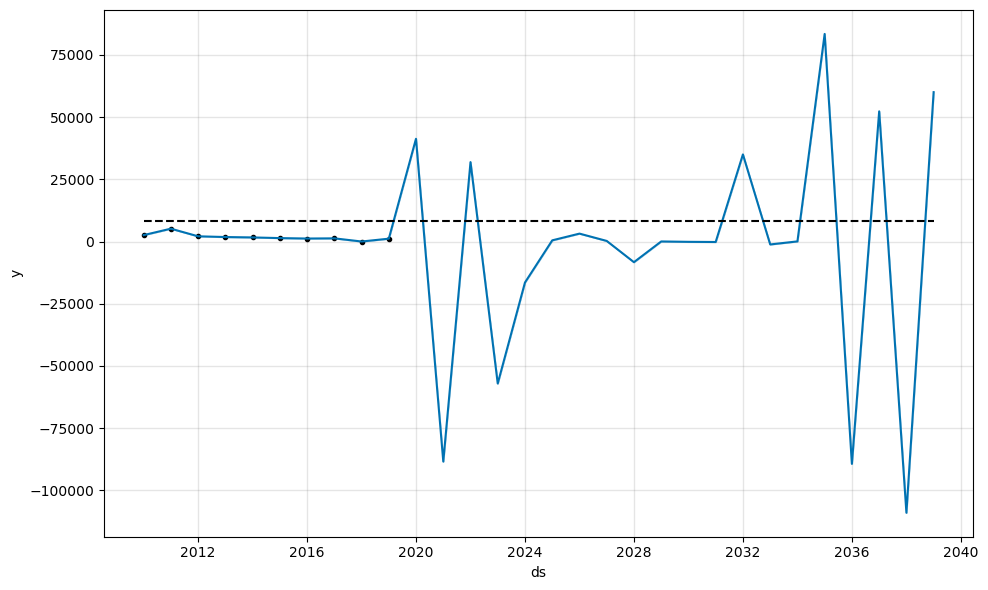

In [40]:
train_model_yearly.plot_forecast()

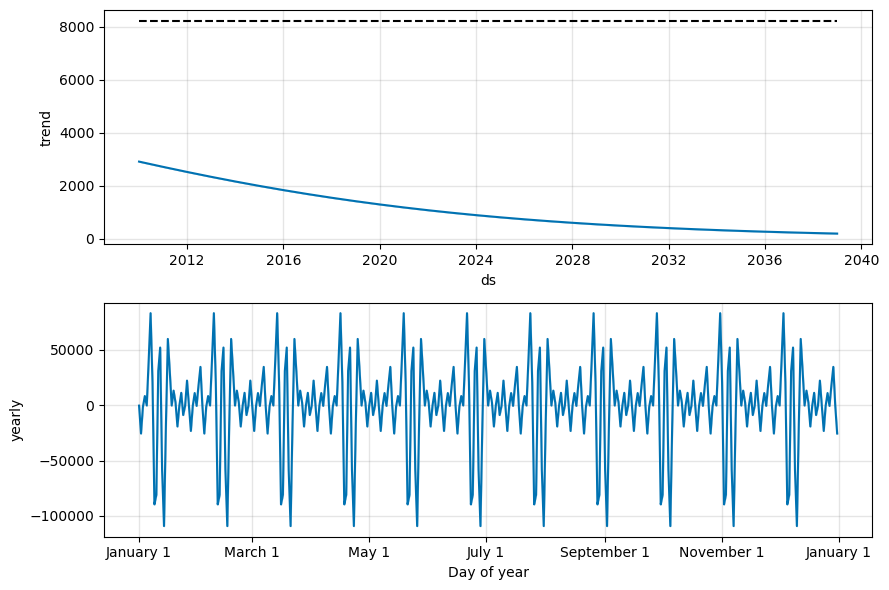

In [41]:
train_model_yearly.plot_forecast_components()